# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

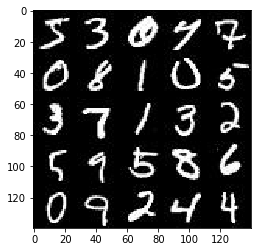

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

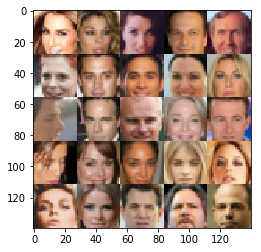

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [24]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='learn_rate')

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [25]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer 28 x 28 x 3
        x1 = tf.layers.conv2d(images, 64, 5, 2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14 x 14 x 64
        
        x2 = tf.layers.conv2d(x1, 128, 5, 2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7 x 7 x 128
        
        x3 = tf.layers.conv2d(x2, 256, 5, 1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7 x 7 x 256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [26]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7 x 7 x 512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14 x 14 x 256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28 x 28 x 128

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 1, padding='same')
        # 28 x 28 x 3

        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [36]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps = 0
    losses = []
    tf.reset_default_graph()
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 50 == 0:
                    _ = show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5905... Generator Loss: 24.8483
Epoch 1/2... Discriminator Loss: 0.0381... Generator Loss: 28.0611
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 23.0848
Epoch 1/2... Discriminator Loss: 0.0080... Generator Loss: 15.1003
Epoch 1/2... Discriminator Loss: 0.0204... Generator Loss: 17.2608


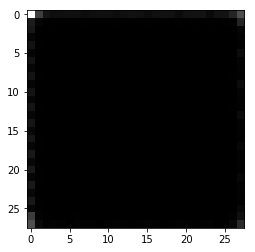

Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.6245
Epoch 1/2... Discriminator Loss: 0.0080... Generator Loss: 8.8818
Epoch 1/2... Discriminator Loss: 0.0027... Generator Loss: 6.1079
Epoch 1/2... Discriminator Loss: 0.0063... Generator Loss: 5.7554
Epoch 1/2... Discriminator Loss: 0.0020... Generator Loss: 6.2869


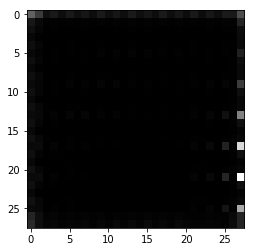

Epoch 1/2... Discriminator Loss: 0.0061... Generator Loss: 5.2375
Epoch 1/2... Discriminator Loss: 0.0012... Generator Loss: 6.7871
Epoch 1/2... Discriminator Loss: 0.0014... Generator Loss: 6.6957
Epoch 1/2... Discriminator Loss: 0.0355... Generator Loss: 6.0022
Epoch 1/2... Discriminator Loss: 0.0417... Generator Loss: 3.7346


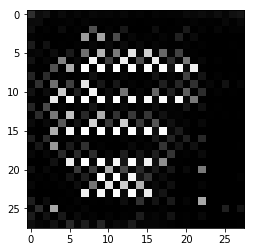

Epoch 1/2... Discriminator Loss: 3.1256... Generator Loss: 1.1470
Epoch 1/2... Discriminator Loss: 2.1054... Generator Loss: 4.2404
Epoch 1/2... Discriminator Loss: 3.7612... Generator Loss: 0.1209
Epoch 1/2... Discriminator Loss: 3.8446... Generator Loss: 0.0393
Epoch 1/2... Discriminator Loss: 3.7884... Generator Loss: 5.8412


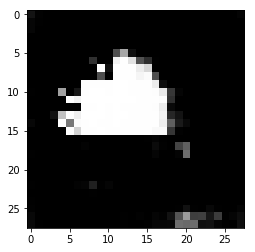

Epoch 1/2... Discriminator Loss: 1.7872... Generator Loss: 0.6580
Epoch 1/2... Discriminator Loss: 2.8997... Generator Loss: 0.7368
Epoch 1/2... Discriminator Loss: 1.5397... Generator Loss: 1.0489
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.5895
Epoch 1/2... Discriminator Loss: 1.8793... Generator Loss: 0.7581


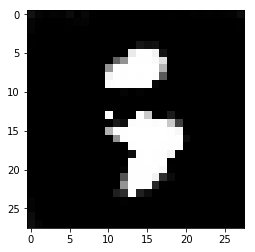

Epoch 1/2... Discriminator Loss: 1.4479... Generator Loss: 0.5009
Epoch 1/2... Discriminator Loss: 1.9512... Generator Loss: 0.7457
Epoch 1/2... Discriminator Loss: 2.1470... Generator Loss: 0.3648
Epoch 1/2... Discriminator Loss: 1.3649... Generator Loss: 0.5914
Epoch 1/2... Discriminator Loss: 2.1919... Generator Loss: 1.3041


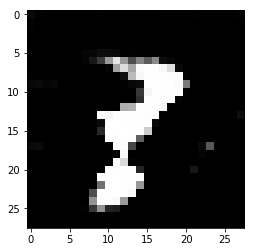

Epoch 1/2... Discriminator Loss: 1.7327... Generator Loss: 1.0760
Epoch 1/2... Discriminator Loss: 2.6219... Generator Loss: 0.2218
Epoch 1/2... Discriminator Loss: 1.6998... Generator Loss: 0.4405
Epoch 1/2... Discriminator Loss: 2.9896... Generator Loss: 0.0874
Epoch 1/2... Discriminator Loss: 1.9014... Generator Loss: 0.5926


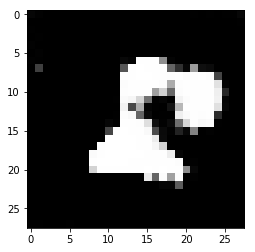

Epoch 1/2... Discriminator Loss: 1.5579... Generator Loss: 2.1947
Epoch 1/2... Discriminator Loss: 1.7877... Generator Loss: 0.9546
Epoch 1/2... Discriminator Loss: 1.3969... Generator Loss: 0.6476
Epoch 1/2... Discriminator Loss: 2.1840... Generator Loss: 1.1300
Epoch 1/2... Discriminator Loss: 2.3902... Generator Loss: 0.1560


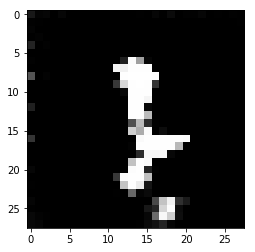

Epoch 1/2... Discriminator Loss: 2.5595... Generator Loss: 0.1074
Epoch 1/2... Discriminator Loss: 2.0867... Generator Loss: 0.2463
Epoch 1/2... Discriminator Loss: 1.2174... Generator Loss: 1.4037
Epoch 1/2... Discriminator Loss: 1.3819... Generator Loss: 0.7385
Epoch 1/2... Discriminator Loss: 1.4973... Generator Loss: 0.7701


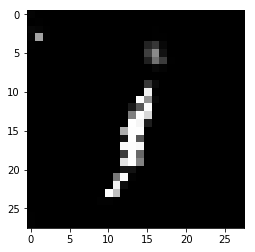

Epoch 1/2... Discriminator Loss: 1.5289... Generator Loss: 0.7385
Epoch 1/2... Discriminator Loss: 0.8509... Generator Loss: 1.0309
Epoch 1/2... Discriminator Loss: 2.4568... Generator Loss: 0.4479
Epoch 1/2... Discriminator Loss: 1.2022... Generator Loss: 0.7390
Epoch 1/2... Discriminator Loss: 1.4222... Generator Loss: 0.6856


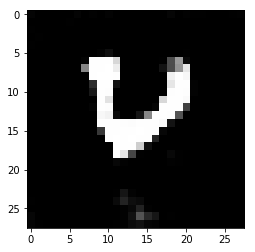

Epoch 1/2... Discriminator Loss: 1.4340... Generator Loss: 1.2880
Epoch 1/2... Discriminator Loss: 0.9490... Generator Loss: 0.8584
Epoch 1/2... Discriminator Loss: 1.0231... Generator Loss: 1.9195
Epoch 1/2... Discriminator Loss: 1.1425... Generator Loss: 0.9821
Epoch 1/2... Discriminator Loss: 1.8060... Generator Loss: 1.0359


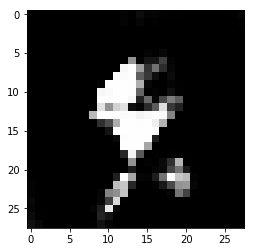

Epoch 1/2... Discriminator Loss: 1.5147... Generator Loss: 0.4648
Epoch 1/2... Discriminator Loss: 1.2451... Generator Loss: 1.1121
Epoch 1/2... Discriminator Loss: 2.2989... Generator Loss: 0.1650
Epoch 1/2... Discriminator Loss: 1.2151... Generator Loss: 1.0583
Epoch 1/2... Discriminator Loss: 1.6882... Generator Loss: 0.2678


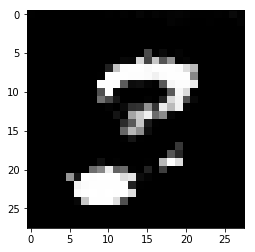

Epoch 1/2... Discriminator Loss: 2.1338... Generator Loss: 3.0041
Epoch 1/2... Discriminator Loss: 2.4232... Generator Loss: 0.1481
Epoch 1/2... Discriminator Loss: 0.8949... Generator Loss: 0.8367
Epoch 1/2... Discriminator Loss: 1.7084... Generator Loss: 0.5195
Epoch 1/2... Discriminator Loss: 1.6991... Generator Loss: 1.6809


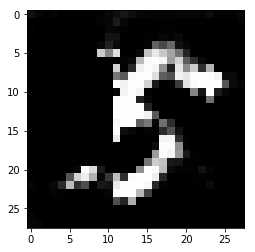

Epoch 1/2... Discriminator Loss: 1.5251... Generator Loss: 0.8725
Epoch 1/2... Discriminator Loss: 1.6175... Generator Loss: 0.5868
Epoch 1/2... Discriminator Loss: 1.0939... Generator Loss: 0.9003
Epoch 1/2... Discriminator Loss: 1.1070... Generator Loss: 1.2879
Epoch 1/2... Discriminator Loss: 1.5599... Generator Loss: 0.4060


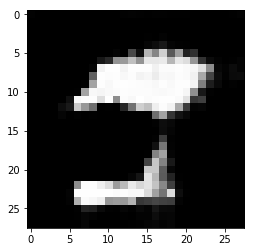

Epoch 1/2... Discriminator Loss: 1.7957... Generator Loss: 0.4389
Epoch 1/2... Discriminator Loss: 2.1912... Generator Loss: 0.4090
Epoch 1/2... Discriminator Loss: 1.2012... Generator Loss: 0.8060
Epoch 1/2... Discriminator Loss: 1.1865... Generator Loss: 0.5984
Epoch 1/2... Discriminator Loss: 1.2899... Generator Loss: 0.4130


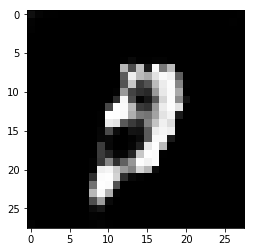

Epoch 1/2... Discriminator Loss: 1.6890... Generator Loss: 1.4225
Epoch 1/2... Discriminator Loss: 1.4673... Generator Loss: 1.0934
Epoch 1/2... Discriminator Loss: 1.2683... Generator Loss: 0.9963
Epoch 1/2... Discriminator Loss: 1.6026... Generator Loss: 0.8414
Epoch 1/2... Discriminator Loss: 1.6031... Generator Loss: 0.3854


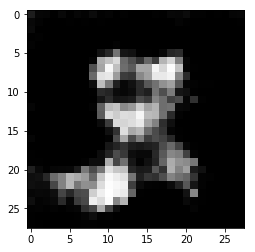

Epoch 1/2... Discriminator Loss: 1.8903... Generator Loss: 1.0299
Epoch 1/2... Discriminator Loss: 1.1761... Generator Loss: 0.8960
Epoch 1/2... Discriminator Loss: 1.0135... Generator Loss: 1.1957
Epoch 1/2... Discriminator Loss: 1.4103... Generator Loss: 0.5355
Epoch 1/2... Discriminator Loss: 2.3817... Generator Loss: 0.2111


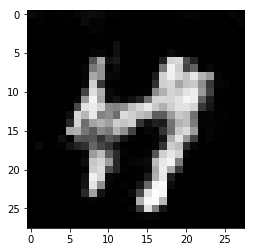

Epoch 1/2... Discriminator Loss: 1.3388... Generator Loss: 0.6795
Epoch 1/2... Discriminator Loss: 2.2777... Generator Loss: 0.1408
Epoch 1/2... Discriminator Loss: 1.3735... Generator Loss: 0.7611
Epoch 1/2... Discriminator Loss: 1.7434... Generator Loss: 0.3841
Epoch 1/2... Discriminator Loss: 1.3431... Generator Loss: 1.3681


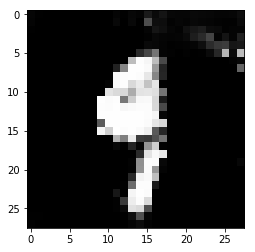

Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 0.8198
Epoch 1/2... Discriminator Loss: 1.2344... Generator Loss: 0.6052
Epoch 1/2... Discriminator Loss: 1.5903... Generator Loss: 0.3661
Epoch 1/2... Discriminator Loss: 1.4794... Generator Loss: 0.7603
Epoch 1/2... Discriminator Loss: 1.8282... Generator Loss: 0.2493


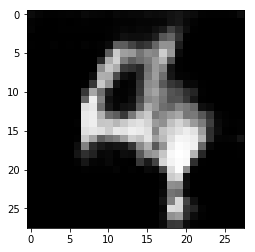

Epoch 1/2... Discriminator Loss: 1.2267... Generator Loss: 0.8626
Epoch 1/2... Discriminator Loss: 1.3293... Generator Loss: 1.1923
Epoch 1/2... Discriminator Loss: 1.2802... Generator Loss: 0.9536
Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 0.4791
Epoch 1/2... Discriminator Loss: 1.2032... Generator Loss: 0.9842


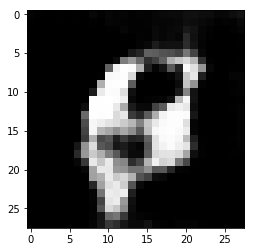

Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 0.5935
Epoch 1/2... Discriminator Loss: 1.2081... Generator Loss: 0.7334
Epoch 1/2... Discriminator Loss: 1.5755... Generator Loss: 0.7627
Epoch 1/2... Discriminator Loss: 1.4776... Generator Loss: 0.4626
Epoch 1/2... Discriminator Loss: 1.8606... Generator Loss: 0.8530


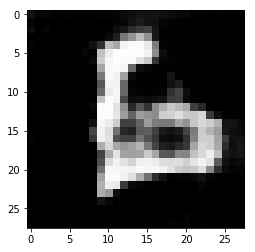

Epoch 1/2... Discriminator Loss: 1.3407... Generator Loss: 1.0589
Epoch 1/2... Discriminator Loss: 1.5230... Generator Loss: 1.1497
Epoch 1/2... Discriminator Loss: 1.5168... Generator Loss: 0.9110
Epoch 1/2... Discriminator Loss: 1.3627... Generator Loss: 0.9241
Epoch 1/2... Discriminator Loss: 1.2990... Generator Loss: 0.4335


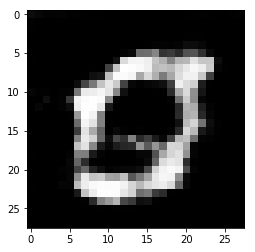

Epoch 1/2... Discriminator Loss: 1.4366... Generator Loss: 1.4377
Epoch 1/2... Discriminator Loss: 1.6451... Generator Loss: 1.3176
Epoch 1/2... Discriminator Loss: 1.4834... Generator Loss: 0.5824
Epoch 1/2... Discriminator Loss: 1.6415... Generator Loss: 0.5665
Epoch 1/2... Discriminator Loss: 1.2012... Generator Loss: 0.7624


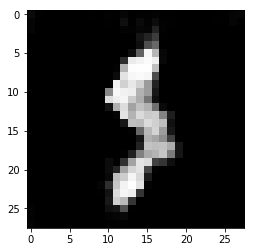

Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 1.0899
Epoch 1/2... Discriminator Loss: 1.5129... Generator Loss: 0.5023
Epoch 1/2... Discriminator Loss: 1.1841... Generator Loss: 0.7207
Epoch 1/2... Discriminator Loss: 1.2547... Generator Loss: 1.2540
Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.9475


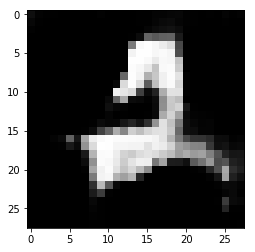

Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 1.3822
Epoch 1/2... Discriminator Loss: 1.3481... Generator Loss: 0.9340
Epoch 1/2... Discriminator Loss: 1.2873... Generator Loss: 0.6749
Epoch 1/2... Discriminator Loss: 0.9816... Generator Loss: 1.1125
Epoch 1/2... Discriminator Loss: 1.3399... Generator Loss: 1.2376


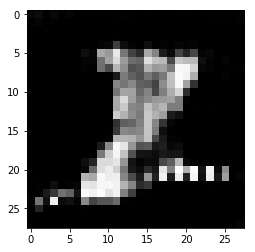

Epoch 1/2... Discriminator Loss: 1.2011... Generator Loss: 0.7411
Epoch 1/2... Discriminator Loss: 1.2712... Generator Loss: 1.0090
Epoch 1/2... Discriminator Loss: 1.2463... Generator Loss: 0.7063
Epoch 1/2... Discriminator Loss: 1.1978... Generator Loss: 0.8343
Epoch 1/2... Discriminator Loss: 1.4626... Generator Loss: 1.3091


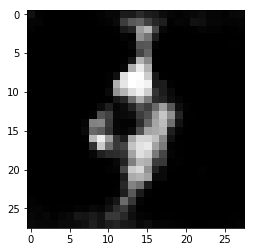

Epoch 1/2... Discriminator Loss: 1.4253... Generator Loss: 0.4684
Epoch 1/2... Discriminator Loss: 1.5825... Generator Loss: 0.4636
Epoch 1/2... Discriminator Loss: 1.7135... Generator Loss: 0.3147
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 0.6498
Epoch 1/2... Discriminator Loss: 1.3269... Generator Loss: 0.5444


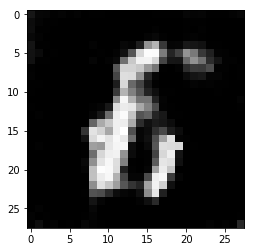

Epoch 1/2... Discriminator Loss: 1.4216... Generator Loss: 0.4512
Epoch 1/2... Discriminator Loss: 1.3240... Generator Loss: 0.6946
Epoch 1/2... Discriminator Loss: 1.2688... Generator Loss: 1.0173
Epoch 1/2... Discriminator Loss: 1.1547... Generator Loss: 0.9289
Epoch 1/2... Discriminator Loss: 1.3039... Generator Loss: 0.9465


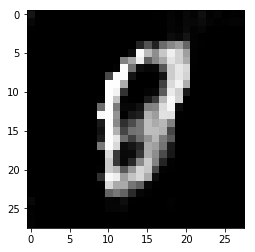

Epoch 1/2... Discriminator Loss: 1.4948... Generator Loss: 0.9583
Epoch 1/2... Discriminator Loss: 1.6193... Generator Loss: 0.7633
Epoch 1/2... Discriminator Loss: 1.3906... Generator Loss: 0.6214
Epoch 1/2... Discriminator Loss: 1.2113... Generator Loss: 0.5646
Epoch 1/2... Discriminator Loss: 1.0886... Generator Loss: 0.9778


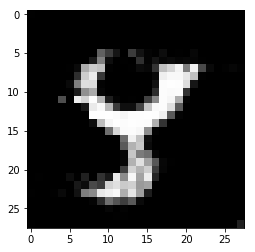

Epoch 1/2... Discriminator Loss: 1.1098... Generator Loss: 0.7126
Epoch 1/2... Discriminator Loss: 1.4033... Generator Loss: 0.6153
Epoch 1/2... Discriminator Loss: 1.3580... Generator Loss: 0.6861
Epoch 1/2... Discriminator Loss: 1.4718... Generator Loss: 1.1864
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 1.0754


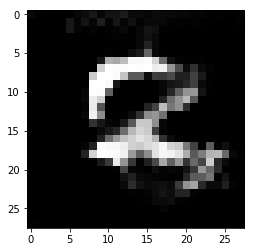

Epoch 1/2... Discriminator Loss: 1.1493... Generator Loss: 0.8428
Epoch 1/2... Discriminator Loss: 1.3820... Generator Loss: 1.0730
Epoch 1/2... Discriminator Loss: 1.6426... Generator Loss: 0.4711
Epoch 1/2... Discriminator Loss: 1.3780... Generator Loss: 0.7825
Epoch 1/2... Discriminator Loss: 1.1125... Generator Loss: 0.8557


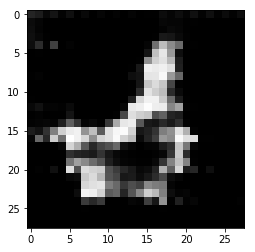

Epoch 1/2... Discriminator Loss: 1.5730... Generator Loss: 0.3985
Epoch 1/2... Discriminator Loss: 1.3057... Generator Loss: 1.0309
Epoch 1/2... Discriminator Loss: 1.3344... Generator Loss: 0.6000
Epoch 1/2... Discriminator Loss: 1.5085... Generator Loss: 0.5575
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 0.8845


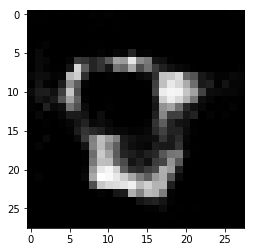

Epoch 1/2... Discriminator Loss: 1.2815... Generator Loss: 0.6661
Epoch 1/2... Discriminator Loss: 1.0118... Generator Loss: 1.3736
Epoch 1/2... Discriminator Loss: 1.7385... Generator Loss: 1.0484
Epoch 1/2... Discriminator Loss: 1.4750... Generator Loss: 1.4531
Epoch 1/2... Discriminator Loss: 1.3555... Generator Loss: 0.6327


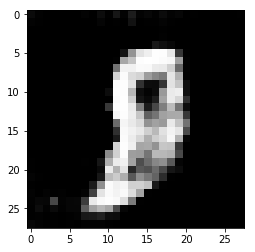

Epoch 1/2... Discriminator Loss: 1.2796... Generator Loss: 0.7275
Epoch 1/2... Discriminator Loss: 1.1558... Generator Loss: 0.8801
Epoch 1/2... Discriminator Loss: 1.6092... Generator Loss: 0.4632
Epoch 1/2... Discriminator Loss: 1.1940... Generator Loss: 0.6064
Epoch 1/2... Discriminator Loss: 1.3010... Generator Loss: 0.7154


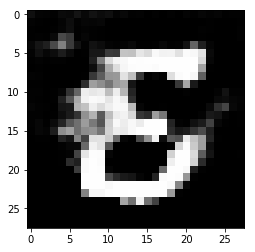

Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 0.8031
Epoch 1/2... Discriminator Loss: 1.4384... Generator Loss: 0.6036
Epoch 1/2... Discriminator Loss: 1.4706... Generator Loss: 1.1527
Epoch 1/2... Discriminator Loss: 1.1660... Generator Loss: 0.7060
Epoch 1/2... Discriminator Loss: 1.0821... Generator Loss: 0.9220


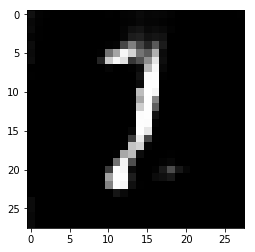

Epoch 1/2... Discriminator Loss: 1.4413... Generator Loss: 0.9828
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 0.7769
Epoch 1/2... Discriminator Loss: 1.5066... Generator Loss: 0.5096
Epoch 1/2... Discriminator Loss: 1.3332... Generator Loss: 1.2591
Epoch 1/2... Discriminator Loss: 1.5430... Generator Loss: 0.5715


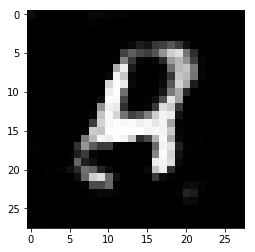

Epoch 1/2... Discriminator Loss: 1.1474... Generator Loss: 1.1982
Epoch 1/2... Discriminator Loss: 1.2211... Generator Loss: 0.9570
Epoch 1/2... Discriminator Loss: 1.5112... Generator Loss: 1.1381
Epoch 1/2... Discriminator Loss: 1.2668... Generator Loss: 1.0517
Epoch 1/2... Discriminator Loss: 1.3753... Generator Loss: 0.5236


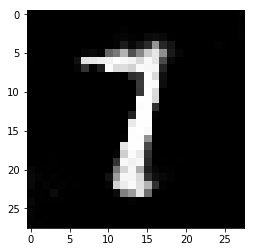

Epoch 1/2... Discriminator Loss: 1.4638... Generator Loss: 0.5955
Epoch 1/2... Discriminator Loss: 1.0482... Generator Loss: 0.7383
Epoch 1/2... Discriminator Loss: 1.3785... Generator Loss: 0.8525
Epoch 1/2... Discriminator Loss: 1.3350... Generator Loss: 1.1428
Epoch 1/2... Discriminator Loss: 1.1799... Generator Loss: 0.7539


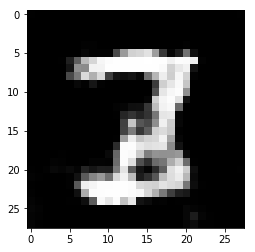

Epoch 1/2... Discriminator Loss: 1.5939... Generator Loss: 0.4233
Epoch 1/2... Discriminator Loss: 1.5575... Generator Loss: 0.6877
Epoch 1/2... Discriminator Loss: 1.1040... Generator Loss: 0.7433
Epoch 1/2... Discriminator Loss: 1.5512... Generator Loss: 0.5926
Epoch 1/2... Discriminator Loss: 1.6727... Generator Loss: 0.6492


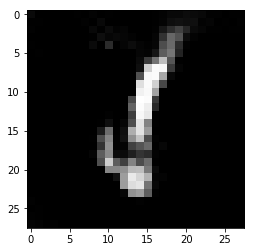

Epoch 1/2... Discriminator Loss: 1.0974... Generator Loss: 0.6791
Epoch 1/2... Discriminator Loss: 1.3115... Generator Loss: 0.7531
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 0.7726
Epoch 1/2... Discriminator Loss: 1.4945... Generator Loss: 0.6925
Epoch 1/2... Discriminator Loss: 1.2255... Generator Loss: 0.8773


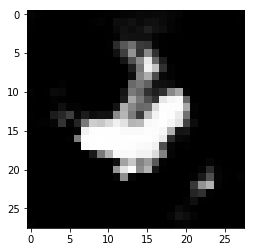

Epoch 1/2... Discriminator Loss: 1.3142... Generator Loss: 0.6884
Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 0.5314
Epoch 1/2... Discriminator Loss: 1.6444... Generator Loss: 0.4783
Epoch 1/2... Discriminator Loss: 1.2348... Generator Loss: 0.7298
Epoch 1/2... Discriminator Loss: 1.0793... Generator Loss: 0.9124


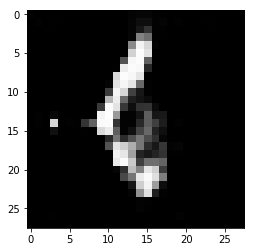

Epoch 1/2... Discriminator Loss: 1.2407... Generator Loss: 0.8490
Epoch 1/2... Discriminator Loss: 1.0219... Generator Loss: 1.1755
Epoch 1/2... Discriminator Loss: 1.2363... Generator Loss: 0.9308
Epoch 1/2... Discriminator Loss: 1.1307... Generator Loss: 0.7770
Epoch 1/2... Discriminator Loss: 1.4765... Generator Loss: 1.1021


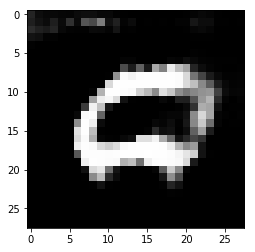

Epoch 1/2... Discriminator Loss: 1.3906... Generator Loss: 0.6641
Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 0.7060
Epoch 1/2... Discriminator Loss: 1.6575... Generator Loss: 0.7786
Epoch 1/2... Discriminator Loss: 1.4854... Generator Loss: 0.4431
Epoch 1/2... Discriminator Loss: 1.1362... Generator Loss: 0.6466


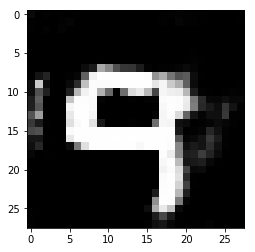

Epoch 1/2... Discriminator Loss: 1.5682... Generator Loss: 0.3740
Epoch 1/2... Discriminator Loss: 1.4877... Generator Loss: 0.5121
Epoch 1/2... Discriminator Loss: 1.3706... Generator Loss: 0.9259
Epoch 1/2... Discriminator Loss: 1.3960... Generator Loss: 1.1314
Epoch 1/2... Discriminator Loss: 1.2069... Generator Loss: 0.8451


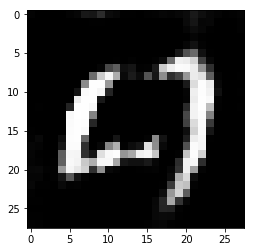

Epoch 1/2... Discriminator Loss: 1.1200... Generator Loss: 0.6260
Epoch 1/2... Discriminator Loss: 1.2959... Generator Loss: 0.9015
Epoch 1/2... Discriminator Loss: 1.7637... Generator Loss: 0.5233
Epoch 1/2... Discriminator Loss: 1.3632... Generator Loss: 0.5428
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 0.9747


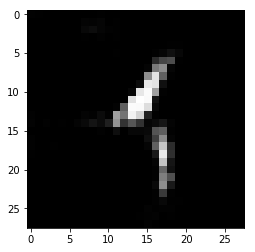

Epoch 1/2... Discriminator Loss: 1.0501... Generator Loss: 0.8902
Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 0.4545
Epoch 1/2... Discriminator Loss: 1.6984... Generator Loss: 0.3610
Epoch 1/2... Discriminator Loss: 1.6379... Generator Loss: 0.7535
Epoch 1/2... Discriminator Loss: 1.4056... Generator Loss: 0.9193


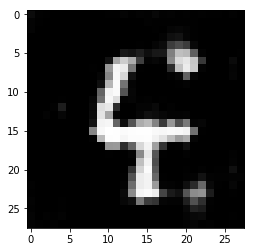

Epoch 1/2... Discriminator Loss: 1.3939... Generator Loss: 0.7745
Epoch 1/2... Discriminator Loss: 1.9414... Generator Loss: 0.5027
Epoch 1/2... Discriminator Loss: 1.0265... Generator Loss: 1.2364
Epoch 1/2... Discriminator Loss: 1.3870... Generator Loss: 0.4864
Epoch 1/2... Discriminator Loss: 1.2600... Generator Loss: 0.7453


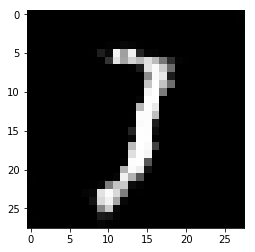

Epoch 1/2... Discriminator Loss: 1.1715... Generator Loss: 0.9025
Epoch 1/2... Discriminator Loss: 1.4306... Generator Loss: 0.3770
Epoch 1/2... Discriminator Loss: 1.3459... Generator Loss: 0.8726
Epoch 1/2... Discriminator Loss: 1.3925... Generator Loss: 0.5063
Epoch 1/2... Discriminator Loss: 1.4309... Generator Loss: 0.6712


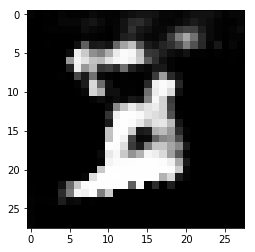

Epoch 1/2... Discriminator Loss: 1.3913... Generator Loss: 0.5372
Epoch 1/2... Discriminator Loss: 0.9665... Generator Loss: 0.8732
Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 1.1040
Epoch 1/2... Discriminator Loss: 1.4398... Generator Loss: 1.0528
Epoch 1/2... Discriminator Loss: 1.2237... Generator Loss: 0.9330


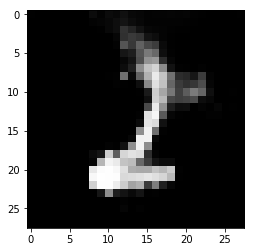

Epoch 1/2... Discriminator Loss: 1.3799... Generator Loss: 0.5118
Epoch 1/2... Discriminator Loss: 1.5097... Generator Loss: 0.6875
Epoch 1/2... Discriminator Loss: 1.4921... Generator Loss: 0.4936
Epoch 1/2... Discriminator Loss: 1.5284... Generator Loss: 0.6017
Epoch 1/2... Discriminator Loss: 1.2824... Generator Loss: 0.8860


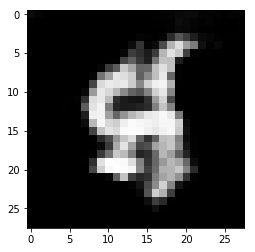

Epoch 1/2... Discriminator Loss: 1.5207... Generator Loss: 1.0371
Epoch 1/2... Discriminator Loss: 1.1813... Generator Loss: 0.6049
Epoch 1/2... Discriminator Loss: 1.4144... Generator Loss: 0.4957
Epoch 1/2... Discriminator Loss: 1.1597... Generator Loss: 0.9315
Epoch 1/2... Discriminator Loss: 1.2007... Generator Loss: 0.7008


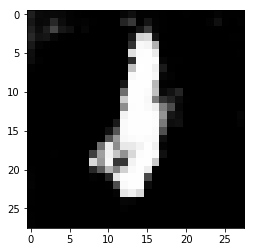

Epoch 1/2... Discriminator Loss: 1.3143... Generator Loss: 0.6095
Epoch 1/2... Discriminator Loss: 1.2739... Generator Loss: 0.5923
Epoch 1/2... Discriminator Loss: 1.3987... Generator Loss: 0.6646
Epoch 1/2... Discriminator Loss: 1.5667... Generator Loss: 0.5495
Epoch 1/2... Discriminator Loss: 1.3176... Generator Loss: 0.8068


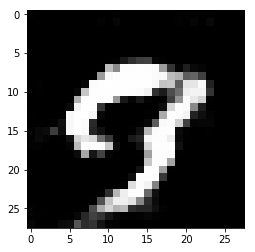

Epoch 1/2... Discriminator Loss: 1.2803... Generator Loss: 0.7397
Epoch 1/2... Discriminator Loss: 1.1658... Generator Loss: 1.0352
Epoch 1/2... Discriminator Loss: 1.0911... Generator Loss: 0.7012
Epoch 1/2... Discriminator Loss: 1.5954... Generator Loss: 0.7268
Epoch 1/2... Discriminator Loss: 1.4455... Generator Loss: 0.8214


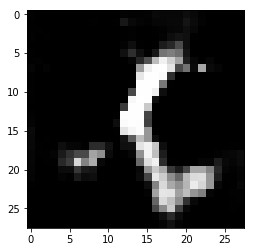

Epoch 1/2... Discriminator Loss: 1.1793... Generator Loss: 0.6782
Epoch 1/2... Discriminator Loss: 1.3632... Generator Loss: 0.5674
Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 0.6922
Epoch 1/2... Discriminator Loss: 1.2985... Generator Loss: 0.9146
Epoch 1/2... Discriminator Loss: 1.3104... Generator Loss: 0.5045


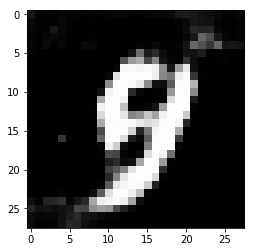

Epoch 1/2... Discriminator Loss: 1.3538... Generator Loss: 0.7495
Epoch 1/2... Discriminator Loss: 1.5489... Generator Loss: 0.5938
Epoch 1/2... Discriminator Loss: 1.2920... Generator Loss: 0.6838
Epoch 1/2... Discriminator Loss: 1.5900... Generator Loss: 0.6157
Epoch 1/2... Discriminator Loss: 1.2280... Generator Loss: 0.6695


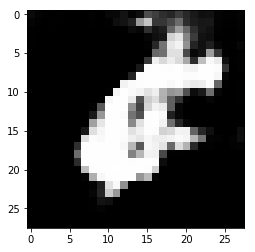

Epoch 1/2... Discriminator Loss: 1.1581... Generator Loss: 1.1462
Epoch 1/2... Discriminator Loss: 1.3259... Generator Loss: 0.7290
Epoch 1/2... Discriminator Loss: 1.2036... Generator Loss: 0.7312
Epoch 1/2... Discriminator Loss: 1.1243... Generator Loss: 0.8148
Epoch 1/2... Discriminator Loss: 1.5445... Generator Loss: 0.4990


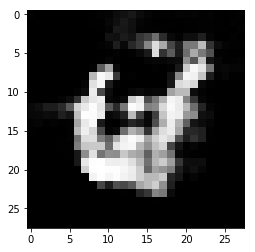

Epoch 1/2... Discriminator Loss: 1.3714... Generator Loss: 0.4972
Epoch 1/2... Discriminator Loss: 1.2554... Generator Loss: 1.0396
Epoch 1/2... Discriminator Loss: 1.2857... Generator Loss: 0.6472
Epoch 1/2... Discriminator Loss: 1.3651... Generator Loss: 0.6998
Epoch 1/2... Discriminator Loss: 1.1686... Generator Loss: 0.7802


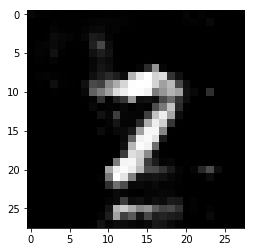

Epoch 1/2... Discriminator Loss: 1.2187... Generator Loss: 1.0812
Epoch 1/2... Discriminator Loss: 1.2080... Generator Loss: 0.8639
Epoch 1/2... Discriminator Loss: 1.3755... Generator Loss: 0.9777
Epoch 1/2... Discriminator Loss: 1.4772... Generator Loss: 0.3513
Epoch 1/2... Discriminator Loss: 1.2710... Generator Loss: 0.7489


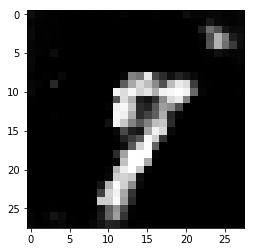

Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 0.5815
Epoch 1/2... Discriminator Loss: 1.1532... Generator Loss: 0.6032
Epoch 1/2... Discriminator Loss: 1.2505... Generator Loss: 0.6290
Epoch 1/2... Discriminator Loss: 1.3291... Generator Loss: 0.7282
Epoch 1/2... Discriminator Loss: 1.4884... Generator Loss: 0.6135


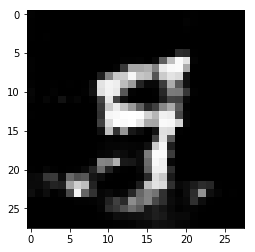

Epoch 1/2... Discriminator Loss: 0.9875... Generator Loss: 1.0584
Epoch 1/2... Discriminator Loss: 1.3028... Generator Loss: 0.6951
Epoch 1/2... Discriminator Loss: 1.6584... Generator Loss: 0.3188
Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 0.8747
Epoch 1/2... Discriminator Loss: 1.2771... Generator Loss: 0.6171


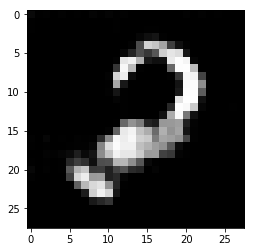

Epoch 1/2... Discriminator Loss: 1.5415... Generator Loss: 0.4682
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.7229
Epoch 1/2... Discriminator Loss: 1.4274... Generator Loss: 0.5358
Epoch 1/2... Discriminator Loss: 1.3108... Generator Loss: 0.7416
Epoch 1/2... Discriminator Loss: 1.3203... Generator Loss: 0.7911


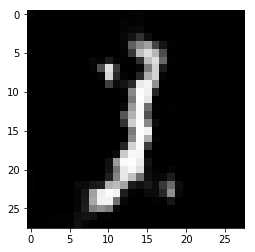

Epoch 1/2... Discriminator Loss: 1.2784... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 1.2918... Generator Loss: 0.8000
Epoch 1/2... Discriminator Loss: 1.2505... Generator Loss: 0.6476
Epoch 1/2... Discriminator Loss: 1.2868... Generator Loss: 0.5352
Epoch 1/2... Discriminator Loss: 1.4197... Generator Loss: 0.5074


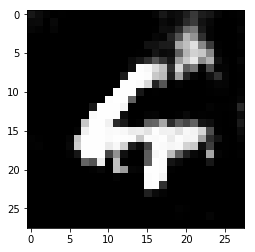

Epoch 1/2... Discriminator Loss: 1.3521... Generator Loss: 0.6926
Epoch 1/2... Discriminator Loss: 1.2486... Generator Loss: 0.9480
Epoch 1/2... Discriminator Loss: 1.2516... Generator Loss: 0.7073
Epoch 1/2... Discriminator Loss: 1.1990... Generator Loss: 1.0264
Epoch 1/2... Discriminator Loss: 1.4719... Generator Loss: 0.4994


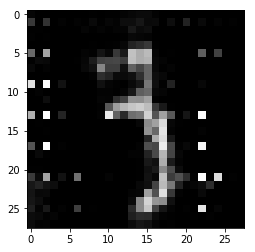

Epoch 1/2... Discriminator Loss: 1.0334... Generator Loss: 0.8715
Epoch 1/2... Discriminator Loss: 1.1496... Generator Loss: 0.8281
Epoch 1/2... Discriminator Loss: 1.0384... Generator Loss: 1.3059
Epoch 1/2... Discriminator Loss: 1.4869... Generator Loss: 0.6392
Epoch 1/2... Discriminator Loss: 1.3559... Generator Loss: 0.5511


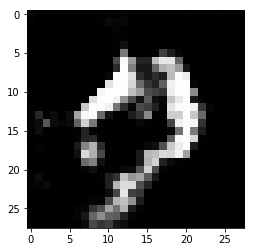

Epoch 1/2... Discriminator Loss: 1.2218... Generator Loss: 0.8419
Epoch 1/2... Discriminator Loss: 1.4310... Generator Loss: 0.4516
Epoch 1/2... Discriminator Loss: 1.3712... Generator Loss: 0.7729
Epoch 1/2... Discriminator Loss: 1.2232... Generator Loss: 0.9168
Epoch 1/2... Discriminator Loss: 1.4330... Generator Loss: 0.7345


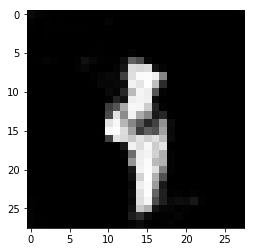

Epoch 1/2... Discriminator Loss: 1.2721... Generator Loss: 0.7875
Epoch 1/2... Discriminator Loss: 1.0723... Generator Loss: 0.8671
Epoch 1/2... Discriminator Loss: 1.4222... Generator Loss: 0.9020
Epoch 1/2... Discriminator Loss: 1.2250... Generator Loss: 0.7229
Epoch 1/2... Discriminator Loss: 1.6469... Generator Loss: 0.5130


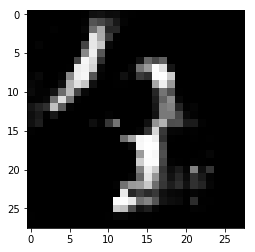

Epoch 1/2... Discriminator Loss: 1.1034... Generator Loss: 0.7881
Epoch 1/2... Discriminator Loss: 1.1911... Generator Loss: 0.8560
Epoch 1/2... Discriminator Loss: 1.4377... Generator Loss: 0.8333
Epoch 1/2... Discriminator Loss: 1.2325... Generator Loss: 0.7242
Epoch 1/2... Discriminator Loss: 1.5956... Generator Loss: 0.4400


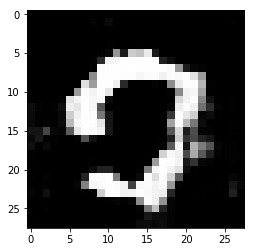

Epoch 1/2... Discriminator Loss: 0.9989... Generator Loss: 1.1539
Epoch 1/2... Discriminator Loss: 1.2874... Generator Loss: 0.7865
Epoch 1/2... Discriminator Loss: 1.2103... Generator Loss: 0.9181
Epoch 1/2... Discriminator Loss: 1.2541... Generator Loss: 0.6189
Epoch 1/2... Discriminator Loss: 1.0145... Generator Loss: 0.8532


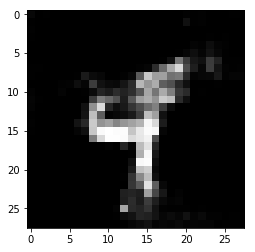

Epoch 1/2... Discriminator Loss: 1.4722... Generator Loss: 0.6305
Epoch 1/2... Discriminator Loss: 1.2500... Generator Loss: 0.9132
Epoch 1/2... Discriminator Loss: 1.1848... Generator Loss: 0.6330
Epoch 1/2... Discriminator Loss: 1.3330... Generator Loss: 0.5634
Epoch 1/2... Discriminator Loss: 1.0735... Generator Loss: 0.9544


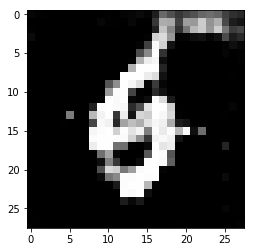

Epoch 1/2... Discriminator Loss: 1.3470... Generator Loss: 0.6501
Epoch 1/2... Discriminator Loss: 1.3771... Generator Loss: 0.6259
Epoch 1/2... Discriminator Loss: 1.1635... Generator Loss: 0.7790
Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 0.6831
Epoch 1/2... Discriminator Loss: 1.1489... Generator Loss: 0.9630


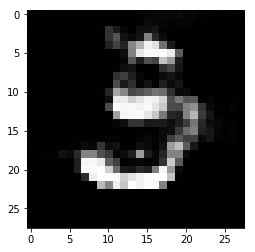

Epoch 1/2... Discriminator Loss: 1.2604... Generator Loss: 1.0065
Epoch 1/2... Discriminator Loss: 1.2398... Generator Loss: 0.8003
Epoch 1/2... Discriminator Loss: 1.5853... Generator Loss: 0.5933
Epoch 1/2... Discriminator Loss: 1.5949... Generator Loss: 0.3901
Epoch 1/2... Discriminator Loss: 1.2682... Generator Loss: 0.9309


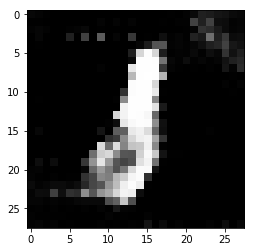

Epoch 1/2... Discriminator Loss: 1.2222... Generator Loss: 0.7720
Epoch 1/2... Discriminator Loss: 1.4484... Generator Loss: 0.6930
Epoch 1/2... Discriminator Loss: 1.1678... Generator Loss: 0.7623
Epoch 1/2... Discriminator Loss: 1.6212... Generator Loss: 0.5909
Epoch 1/2... Discriminator Loss: 0.9388... Generator Loss: 1.2526


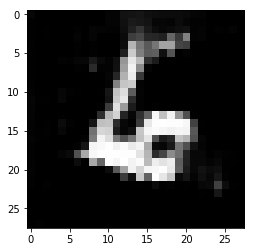

Epoch 1/2... Discriminator Loss: 1.2905... Generator Loss: 0.8748
Epoch 1/2... Discriminator Loss: 1.7061... Generator Loss: 0.5252
Epoch 1/2... Discriminator Loss: 1.4039... Generator Loss: 0.6177
Epoch 1/2... Discriminator Loss: 1.1727... Generator Loss: 0.7290
Epoch 1/2... Discriminator Loss: 1.3890... Generator Loss: 0.6194


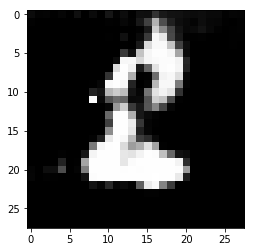

Epoch 1/2... Discriminator Loss: 1.3309... Generator Loss: 0.7015
Epoch 1/2... Discriminator Loss: 1.2388... Generator Loss: 0.7966
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.9109
Epoch 1/2... Discriminator Loss: 1.1712... Generator Loss: 0.6521
Epoch 1/2... Discriminator Loss: 1.2342... Generator Loss: 0.6397


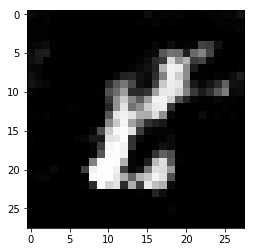

Epoch 1/2... Discriminator Loss: 1.1693... Generator Loss: 0.8347
Epoch 1/2... Discriminator Loss: 1.3257... Generator Loss: 0.7871
Epoch 1/2... Discriminator Loss: 1.1832... Generator Loss: 0.8101
Epoch 1/2... Discriminator Loss: 1.3490... Generator Loss: 0.7018
Epoch 1/2... Discriminator Loss: 1.6184... Generator Loss: 0.5197


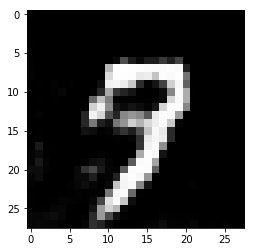

Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 1.1111
Epoch 1/2... Discriminator Loss: 1.5462... Generator Loss: 0.7012
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.4846
Epoch 1/2... Discriminator Loss: 1.1723... Generator Loss: 0.6135
Epoch 1/2... Discriminator Loss: 1.2966... Generator Loss: 0.5804


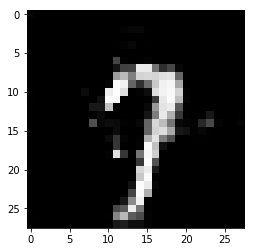

Epoch 1/2... Discriminator Loss: 1.4100... Generator Loss: 0.5165
Epoch 1/2... Discriminator Loss: 1.2722... Generator Loss: 0.6873
Epoch 1/2... Discriminator Loss: 1.4173... Generator Loss: 0.5182
Epoch 1/2... Discriminator Loss: 1.0611... Generator Loss: 1.3401
Epoch 1/2... Discriminator Loss: 1.3706... Generator Loss: 0.8130


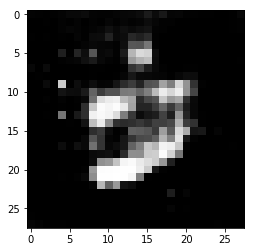

Epoch 1/2... Discriminator Loss: 1.0851... Generator Loss: 0.8206
Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 0.6410
Epoch 1/2... Discriminator Loss: 1.7083... Generator Loss: 0.5690
Epoch 1/2... Discriminator Loss: 1.1749... Generator Loss: 0.7807
Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 0.8537


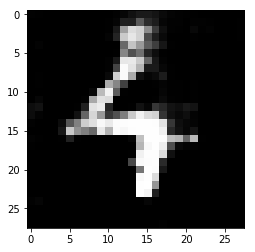

Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 0.4330
Epoch 1/2... Discriminator Loss: 1.2730... Generator Loss: 0.8150
Epoch 1/2... Discriminator Loss: 1.1971... Generator Loss: 0.7524
Epoch 1/2... Discriminator Loss: 1.2022... Generator Loss: 0.8645
Epoch 1/2... Discriminator Loss: 1.2465... Generator Loss: 0.7435


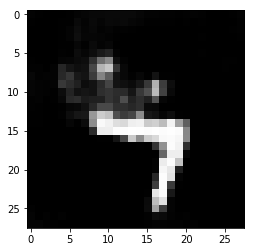

Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 0.7866
Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 0.9658
Epoch 1/2... Discriminator Loss: 1.3331... Generator Loss: 0.7283
Epoch 1/2... Discriminator Loss: 1.2279... Generator Loss: 0.7311
Epoch 1/2... Discriminator Loss: 1.2530... Generator Loss: 1.0037


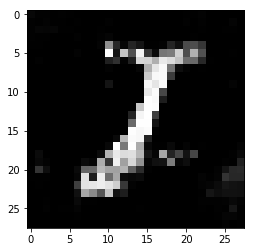

Epoch 1/2... Discriminator Loss: 1.2817... Generator Loss: 0.8597
Epoch 1/2... Discriminator Loss: 1.1709... Generator Loss: 0.8851
Epoch 1/2... Discriminator Loss: 1.5237... Generator Loss: 0.9656
Epoch 1/2... Discriminator Loss: 1.4260... Generator Loss: 0.4838
Epoch 1/2... Discriminator Loss: 1.3718... Generator Loss: 1.0908


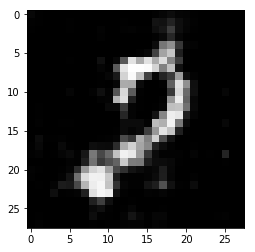

Epoch 1/2... Discriminator Loss: 1.4198... Generator Loss: 0.5354
Epoch 1/2... Discriminator Loss: 1.5860... Generator Loss: 0.8392
Epoch 1/2... Discriminator Loss: 1.0985... Generator Loss: 0.8788
Epoch 1/2... Discriminator Loss: 1.4698... Generator Loss: 0.5869
Epoch 1/2... Discriminator Loss: 1.1949... Generator Loss: 0.6504


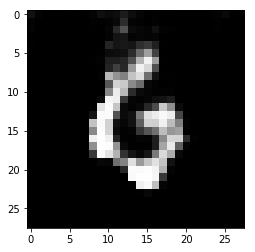

Epoch 1/2... Discriminator Loss: 1.1829... Generator Loss: 0.7384
Epoch 1/2... Discriminator Loss: 1.2046... Generator Loss: 0.7379
Epoch 1/2... Discriminator Loss: 1.3091... Generator Loss: 0.6235
Epoch 1/2... Discriminator Loss: 1.3712... Generator Loss: 0.5798
Epoch 1/2... Discriminator Loss: 1.3511... Generator Loss: 0.6563


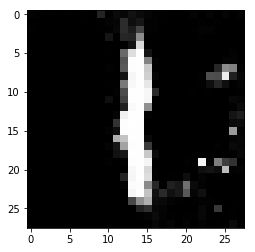

Epoch 1/2... Discriminator Loss: 1.3349... Generator Loss: 1.0618
Epoch 1/2... Discriminator Loss: 1.2958... Generator Loss: 0.8057
Epoch 1/2... Discriminator Loss: 1.1125... Generator Loss: 0.6806
Epoch 1/2... Discriminator Loss: 0.8527... Generator Loss: 1.0725
Epoch 1/2... Discriminator Loss: 1.1457... Generator Loss: 0.7992


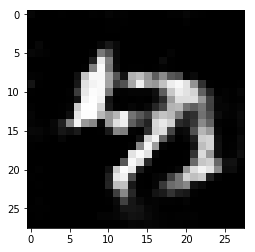

Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 0.6078
Epoch 1/2... Discriminator Loss: 1.3575... Generator Loss: 0.8550
Epoch 1/2... Discriminator Loss: 1.2791... Generator Loss: 1.1338
Epoch 1/2... Discriminator Loss: 1.2859... Generator Loss: 1.0504
Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 0.5899


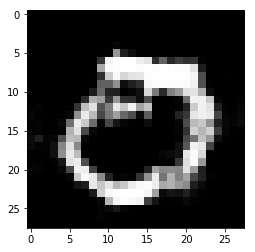

Epoch 1/2... Discriminator Loss: 1.3449... Generator Loss: 0.7022
Epoch 1/2... Discriminator Loss: 0.8476... Generator Loss: 0.9901
Epoch 1/2... Discriminator Loss: 1.4860... Generator Loss: 0.8390
Epoch 1/2... Discriminator Loss: 1.1069... Generator Loss: 0.9100
Epoch 1/2... Discriminator Loss: 1.5655... Generator Loss: 0.5104


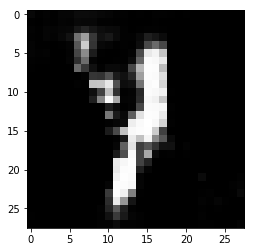

Epoch 1/2... Discriminator Loss: 1.3900... Generator Loss: 0.6186
Epoch 1/2... Discriminator Loss: 1.6588... Generator Loss: 0.4718
Epoch 1/2... Discriminator Loss: 1.4173... Generator Loss: 0.7414
Epoch 1/2... Discriminator Loss: 1.1296... Generator Loss: 0.9562
Epoch 1/2... Discriminator Loss: 1.4441... Generator Loss: 0.5447


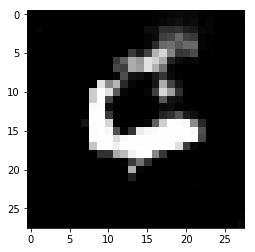

Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 0.6168
Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 0.7198
Epoch 1/2... Discriminator Loss: 1.4870... Generator Loss: 0.6458
Epoch 1/2... Discriminator Loss: 1.1448... Generator Loss: 0.8352
Epoch 1/2... Discriminator Loss: 1.4140... Generator Loss: 0.7374


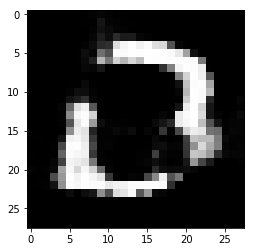

Epoch 1/2... Discriminator Loss: 0.9765... Generator Loss: 1.0169
Epoch 1/2... Discriminator Loss: 1.7664... Generator Loss: 0.4810
Epoch 1/2... Discriminator Loss: 0.9731... Generator Loss: 0.9665
Epoch 1/2... Discriminator Loss: 0.9383... Generator Loss: 1.1241
Epoch 1/2... Discriminator Loss: 1.2010... Generator Loss: 0.7223


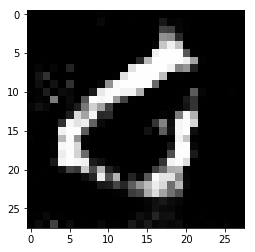

Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 0.7609
Epoch 1/2... Discriminator Loss: 1.4643... Generator Loss: 0.7225
Epoch 1/2... Discriminator Loss: 1.4240... Generator Loss: 0.6084
Epoch 1/2... Discriminator Loss: 1.5401... Generator Loss: 0.5171
Epoch 1/2... Discriminator Loss: 1.4328... Generator Loss: 0.8638


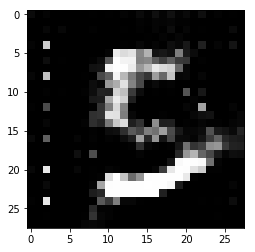

Epoch 1/2... Discriminator Loss: 1.5488... Generator Loss: 0.7200
Epoch 1/2... Discriminator Loss: 1.2997... Generator Loss: 0.7460
Epoch 1/2... Discriminator Loss: 1.4848... Generator Loss: 0.5975
Epoch 1/2... Discriminator Loss: 1.4210... Generator Loss: 0.5501
Epoch 1/2... Discriminator Loss: 1.3680... Generator Loss: 0.9136


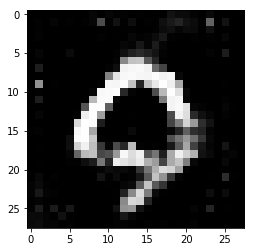

Epoch 1/2... Discriminator Loss: 1.5225... Generator Loss: 0.6752
Epoch 1/2... Discriminator Loss: 1.4434... Generator Loss: 0.6978
Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 0.5711
Epoch 1/2... Discriminator Loss: 0.9951... Generator Loss: 0.9014
Epoch 1/2... Discriminator Loss: 1.4743... Generator Loss: 0.8185


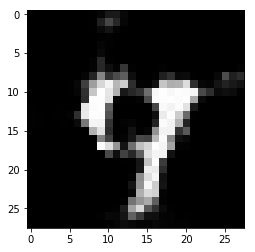

Epoch 1/2... Discriminator Loss: 1.2058... Generator Loss: 0.7549
Epoch 1/2... Discriminator Loss: 1.4944... Generator Loss: 0.8220
Epoch 1/2... Discriminator Loss: 1.1904... Generator Loss: 0.7365
Epoch 1/2... Discriminator Loss: 1.2045... Generator Loss: 0.7031
Epoch 1/2... Discriminator Loss: 1.3479... Generator Loss: 0.6944


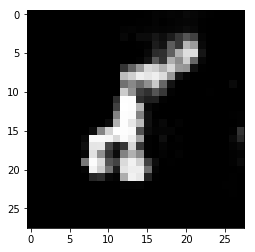

Epoch 1/2... Discriminator Loss: 1.1344... Generator Loss: 0.7766
Epoch 1/2... Discriminator Loss: 1.7531... Generator Loss: 0.7021
Epoch 1/2... Discriminator Loss: 1.0970... Generator Loss: 0.9476
Epoch 1/2... Discriminator Loss: 1.5939... Generator Loss: 0.6255
Epoch 1/2... Discriminator Loss: 1.1124... Generator Loss: 0.8090


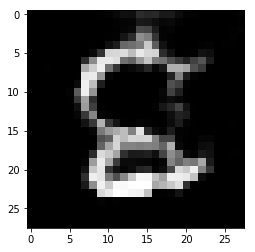

Epoch 1/2... Discriminator Loss: 1.2958... Generator Loss: 0.8841
Epoch 1/2... Discriminator Loss: 1.1700... Generator Loss: 0.8285
Epoch 1/2... Discriminator Loss: 1.0509... Generator Loss: 1.1796
Epoch 1/2... Discriminator Loss: 1.2658... Generator Loss: 0.9101
Epoch 1/2... Discriminator Loss: 1.6278... Generator Loss: 0.5282


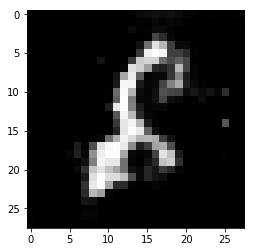

Epoch 1/2... Discriminator Loss: 1.0240... Generator Loss: 0.9202
Epoch 1/2... Discriminator Loss: 1.2910... Generator Loss: 0.7092
Epoch 1/2... Discriminator Loss: 1.3619... Generator Loss: 0.6475
Epoch 1/2... Discriminator Loss: 1.2986... Generator Loss: 0.8185
Epoch 1/2... Discriminator Loss: 1.3690... Generator Loss: 0.5790


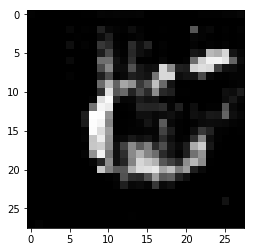

Epoch 1/2... Discriminator Loss: 1.2214... Generator Loss: 0.8675
Epoch 1/2... Discriminator Loss: 1.4248... Generator Loss: 0.5776
Epoch 1/2... Discriminator Loss: 1.2275... Generator Loss: 0.6379
Epoch 1/2... Discriminator Loss: 1.3913... Generator Loss: 0.8567
Epoch 1/2... Discriminator Loss: 1.3102... Generator Loss: 0.7908


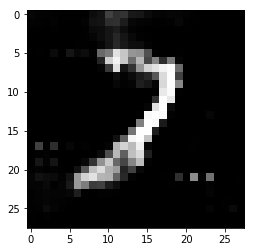

Epoch 1/2... Discriminator Loss: 1.2501... Generator Loss: 0.8876
Epoch 1/2... Discriminator Loss: 1.2386... Generator Loss: 0.8030
Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 0.7510
Epoch 1/2... Discriminator Loss: 1.4437... Generator Loss: 0.4883
Epoch 1/2... Discriminator Loss: 1.3888... Generator Loss: 0.6620


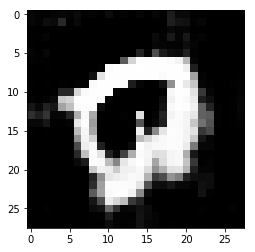

Epoch 1/2... Discriminator Loss: 1.0188... Generator Loss: 0.8075
Epoch 1/2... Discriminator Loss: 1.4478... Generator Loss: 0.5745
Epoch 1/2... Discriminator Loss: 1.4445... Generator Loss: 0.5368
Epoch 1/2... Discriminator Loss: 1.0925... Generator Loss: 0.8888
Epoch 1/2... Discriminator Loss: 1.2705... Generator Loss: 0.7862


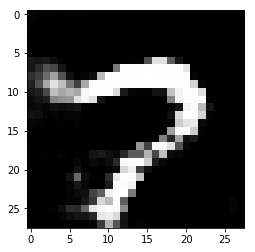

Epoch 1/2... Discriminator Loss: 1.2610... Generator Loss: 0.6989
Epoch 1/2... Discriminator Loss: 1.3432... Generator Loss: 0.5588
Epoch 1/2... Discriminator Loss: 1.1928... Generator Loss: 0.7062
Epoch 1/2... Discriminator Loss: 1.1165... Generator Loss: 0.8509
Epoch 1/2... Discriminator Loss: 1.1710... Generator Loss: 0.8215


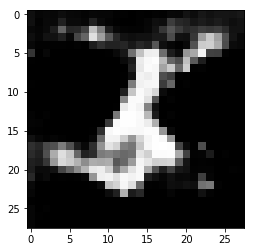

Epoch 1/2... Discriminator Loss: 1.2229... Generator Loss: 0.7009
Epoch 1/2... Discriminator Loss: 1.4707... Generator Loss: 0.7015
Epoch 1/2... Discriminator Loss: 1.2832... Generator Loss: 0.8131
Epoch 1/2... Discriminator Loss: 1.3085... Generator Loss: 0.8344
Epoch 1/2... Discriminator Loss: 1.2260... Generator Loss: 0.7448


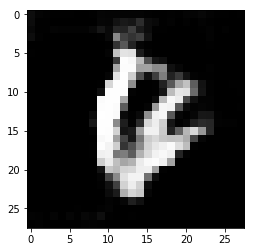

Epoch 1/2... Discriminator Loss: 1.3336... Generator Loss: 0.6731
Epoch 1/2... Discriminator Loss: 1.5118... Generator Loss: 0.6256
Epoch 1/2... Discriminator Loss: 1.4366... Generator Loss: 0.6194
Epoch 1/2... Discriminator Loss: 1.2366... Generator Loss: 0.7214
Epoch 1/2... Discriminator Loss: 1.2789... Generator Loss: 0.9504


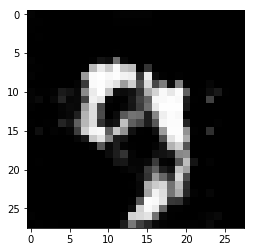

Epoch 1/2... Discriminator Loss: 1.3732... Generator Loss: 0.6876
Epoch 1/2... Discriminator Loss: 1.3987... Generator Loss: 0.7325
Epoch 1/2... Discriminator Loss: 1.3333... Generator Loss: 0.6372
Epoch 1/2... Discriminator Loss: 1.3345... Generator Loss: 0.6088
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.4856


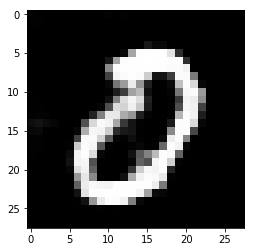

Epoch 1/2... Discriminator Loss: 1.0745... Generator Loss: 0.8336
Epoch 1/2... Discriminator Loss: 1.1679... Generator Loss: 0.8135
Epoch 1/2... Discriminator Loss: 1.6297... Generator Loss: 0.5734
Epoch 1/2... Discriminator Loss: 1.2334... Generator Loss: 0.6040
Epoch 1/2... Discriminator Loss: 1.3103... Generator Loss: 0.7469


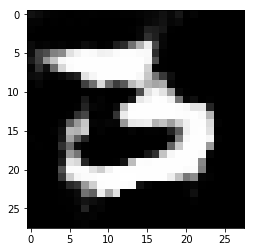

Epoch 1/2... Discriminator Loss: 1.2836... Generator Loss: 0.9213
Epoch 1/2... Discriminator Loss: 1.2162... Generator Loss: 0.6837
Epoch 1/2... Discriminator Loss: 1.4857... Generator Loss: 0.5550
Epoch 1/2... Discriminator Loss: 1.3547... Generator Loss: 0.7308
Epoch 1/2... Discriminator Loss: 1.1605... Generator Loss: 0.8164


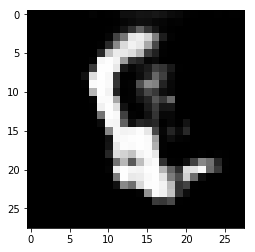

Epoch 1/2... Discriminator Loss: 1.2785... Generator Loss: 0.8755
Epoch 1/2... Discriminator Loss: 1.3697... Generator Loss: 0.7065
Epoch 1/2... Discriminator Loss: 1.3183... Generator Loss: 0.6448
Epoch 1/2... Discriminator Loss: 1.3468... Generator Loss: 0.5877
Epoch 1/2... Discriminator Loss: 1.1584... Generator Loss: 0.8010


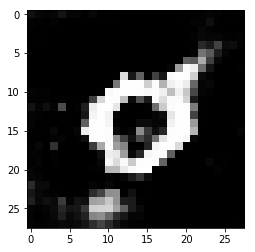

Epoch 1/2... Discriminator Loss: 1.1625... Generator Loss: 0.7513
Epoch 1/2... Discriminator Loss: 1.3974... Generator Loss: 0.6475
Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 1.0008
Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 0.8410
Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 0.9470


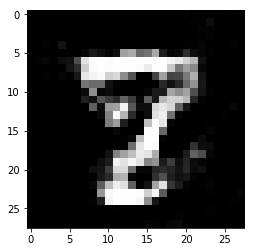

Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 0.6174
Epoch 1/2... Discriminator Loss: 0.9275... Generator Loss: 1.0735
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.5196
Epoch 1/2... Discriminator Loss: 1.2165... Generator Loss: 0.7355
Epoch 1/2... Discriminator Loss: 1.1513... Generator Loss: 0.8796


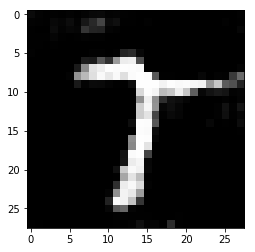

Epoch 1/2... Discriminator Loss: 1.2000... Generator Loss: 0.7051
Epoch 1/2... Discriminator Loss: 1.2986... Generator Loss: 0.6918
Epoch 1/2... Discriminator Loss: 1.3527... Generator Loss: 0.6795
Epoch 1/2... Discriminator Loss: 1.6942... Generator Loss: 0.4629
Epoch 1/2... Discriminator Loss: 1.4178... Generator Loss: 0.6326


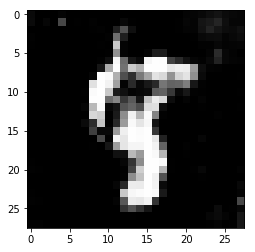

Epoch 1/2... Discriminator Loss: 1.2772... Generator Loss: 0.6667
Epoch 1/2... Discriminator Loss: 1.3030... Generator Loss: 0.7205
Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 0.5210
Epoch 1/2... Discriminator Loss: 1.2809... Generator Loss: 0.9849
Epoch 1/2... Discriminator Loss: 1.5726... Generator Loss: 0.4345


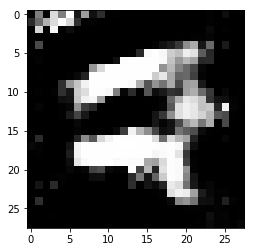

Epoch 1/2... Discriminator Loss: 1.6479... Generator Loss: 0.7181
Epoch 1/2... Discriminator Loss: 1.6104... Generator Loss: 0.5841
Epoch 1/2... Discriminator Loss: 1.3846... Generator Loss: 0.8285
Epoch 1/2... Discriminator Loss: 1.1843... Generator Loss: 0.8666
Epoch 1/2... Discriminator Loss: 1.0852... Generator Loss: 0.9695


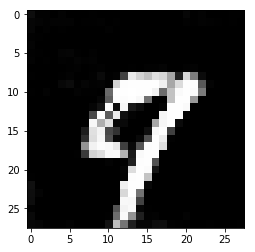

Epoch 1/2... Discriminator Loss: 1.4206... Generator Loss: 1.1838
Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 0.8217
Epoch 1/2... Discriminator Loss: 1.4613... Generator Loss: 0.6531
Epoch 1/2... Discriminator Loss: 1.2104... Generator Loss: 0.5667
Epoch 1/2... Discriminator Loss: 1.4196... Generator Loss: 0.6788


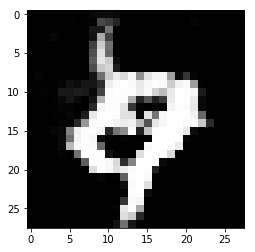

Epoch 1/2... Discriminator Loss: 1.2750... Generator Loss: 0.8427
Epoch 1/2... Discriminator Loss: 1.0293... Generator Loss: 0.8242
Epoch 1/2... Discriminator Loss: 1.2230... Generator Loss: 0.6044
Epoch 1/2... Discriminator Loss: 1.4994... Generator Loss: 0.6770
Epoch 1/2... Discriminator Loss: 1.1791... Generator Loss: 0.7563


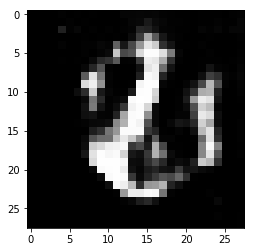

Epoch 1/2... Discriminator Loss: 1.3692... Generator Loss: 0.7194
Epoch 1/2... Discriminator Loss: 1.1998... Generator Loss: 0.5912
Epoch 1/2... Discriminator Loss: 1.2500... Generator Loss: 0.6129
Epoch 1/2... Discriminator Loss: 1.3398... Generator Loss: 0.6385
Epoch 1/2... Discriminator Loss: 1.5953... Generator Loss: 0.5478


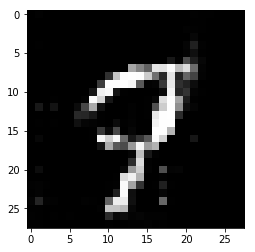

Epoch 1/2... Discriminator Loss: 1.3691... Generator Loss: 0.6694
Epoch 1/2... Discriminator Loss: 1.4444... Generator Loss: 0.7052
Epoch 1/2... Discriminator Loss: 1.3307... Generator Loss: 0.8009
Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 0.8185
Epoch 1/2... Discriminator Loss: 1.2075... Generator Loss: 1.0124


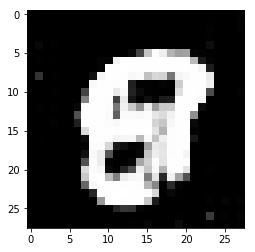

Epoch 1/2... Discriminator Loss: 1.2514... Generator Loss: 0.6579
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 0.7164
Epoch 1/2... Discriminator Loss: 1.2253... Generator Loss: 0.7955
Epoch 1/2... Discriminator Loss: 1.3693... Generator Loss: 0.7094
Epoch 1/2... Discriminator Loss: 1.1283... Generator Loss: 0.8799


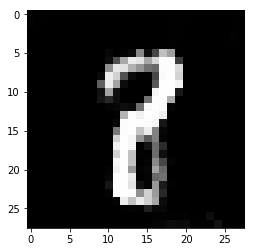

Epoch 1/2... Discriminator Loss: 1.2109... Generator Loss: 0.8572
Epoch 1/2... Discriminator Loss: 1.1844... Generator Loss: 0.6581
Epoch 1/2... Discriminator Loss: 1.5495... Generator Loss: 0.4614
Epoch 1/2... Discriminator Loss: 1.1640... Generator Loss: 0.7920
Epoch 1/2... Discriminator Loss: 1.3155... Generator Loss: 0.7171


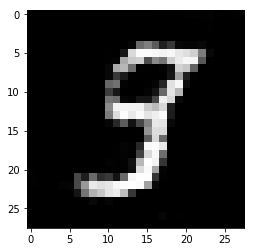

Epoch 1/2... Discriminator Loss: 1.5676... Generator Loss: 0.5193
Epoch 1/2... Discriminator Loss: 1.2692... Generator Loss: 0.8551
Epoch 1/2... Discriminator Loss: 1.3117... Generator Loss: 0.5812
Epoch 1/2... Discriminator Loss: 0.8762... Generator Loss: 1.4391
Epoch 1/2... Discriminator Loss: 1.3513... Generator Loss: 0.9322


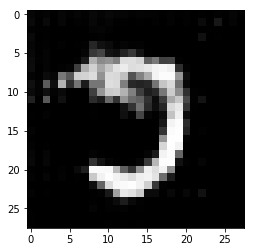

Epoch 1/2... Discriminator Loss: 1.3078... Generator Loss: 0.6309
Epoch 1/2... Discriminator Loss: 1.0528... Generator Loss: 0.8818
Epoch 1/2... Discriminator Loss: 1.3307... Generator Loss: 0.5983
Epoch 1/2... Discriminator Loss: 1.2093... Generator Loss: 0.7096
Epoch 1/2... Discriminator Loss: 1.3971... Generator Loss: 0.6680


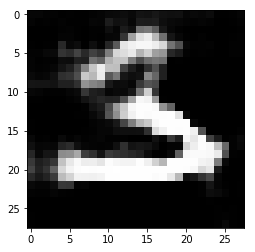

Epoch 1/2... Discriminator Loss: 1.4576... Generator Loss: 0.7553
Epoch 1/2... Discriminator Loss: 1.4981... Generator Loss: 0.5254
Epoch 1/2... Discriminator Loss: 1.1472... Generator Loss: 0.7243
Epoch 1/2... Discriminator Loss: 1.2742... Generator Loss: 0.8029
Epoch 1/2... Discriminator Loss: 1.4712... Generator Loss: 0.5218


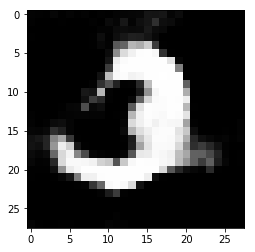

Epoch 2/2... Discriminator Loss: 1.1083... Generator Loss: 0.6327
Epoch 2/2... Discriminator Loss: 1.2855... Generator Loss: 0.7998
Epoch 2/2... Discriminator Loss: 1.3924... Generator Loss: 0.6271
Epoch 2/2... Discriminator Loss: 1.3539... Generator Loss: 0.7331
Epoch 2/2... Discriminator Loss: 1.3996... Generator Loss: 0.5483


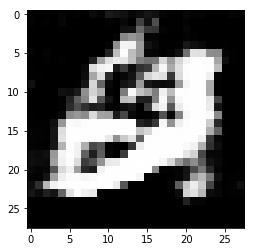

Epoch 2/2... Discriminator Loss: 1.2680... Generator Loss: 0.7606
Epoch 2/2... Discriminator Loss: 1.3664... Generator Loss: 0.6878
Epoch 2/2... Discriminator Loss: 1.2550... Generator Loss: 0.7544
Epoch 2/2... Discriminator Loss: 1.3447... Generator Loss: 0.7172
Epoch 2/2... Discriminator Loss: 1.1761... Generator Loss: 0.7283


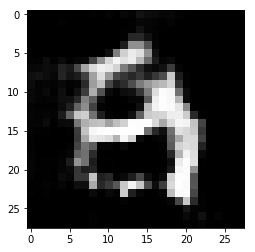

Epoch 2/2... Discriminator Loss: 1.4770... Generator Loss: 0.7668
Epoch 2/2... Discriminator Loss: 1.1268... Generator Loss: 0.9027
Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 0.6624
Epoch 2/2... Discriminator Loss: 1.3443... Generator Loss: 0.6354
Epoch 2/2... Discriminator Loss: 1.5577... Generator Loss: 0.6112


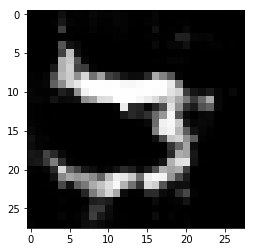

Epoch 2/2... Discriminator Loss: 1.0390... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 1.4237... Generator Loss: 0.7029
Epoch 2/2... Discriminator Loss: 1.2112... Generator Loss: 0.7702
Epoch 2/2... Discriminator Loss: 1.6034... Generator Loss: 0.3446
Epoch 2/2... Discriminator Loss: 1.6989... Generator Loss: 0.4924


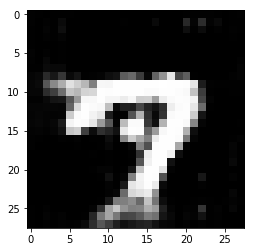

Epoch 2/2... Discriminator Loss: 1.5215... Generator Loss: 0.5827
Epoch 2/2... Discriminator Loss: 1.4719... Generator Loss: 0.4203
Epoch 2/2... Discriminator Loss: 1.4518... Generator Loss: 0.6510
Epoch 2/2... Discriminator Loss: 1.0795... Generator Loss: 0.7999
Epoch 2/2... Discriminator Loss: 1.2506... Generator Loss: 0.7968


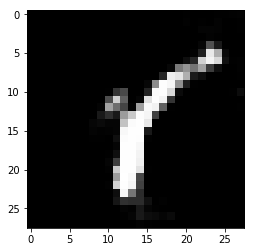

Epoch 2/2... Discriminator Loss: 1.1933... Generator Loss: 0.8122
Epoch 2/2... Discriminator Loss: 1.3463... Generator Loss: 0.6922
Epoch 2/2... Discriminator Loss: 1.2883... Generator Loss: 0.7899
Epoch 2/2... Discriminator Loss: 1.4160... Generator Loss: 0.7960
Epoch 2/2... Discriminator Loss: 1.4266... Generator Loss: 0.5427


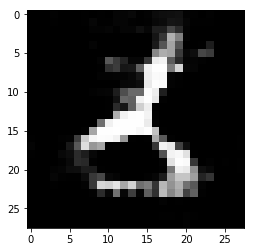

Epoch 2/2... Discriminator Loss: 1.1747... Generator Loss: 0.6751
Epoch 2/2... Discriminator Loss: 1.4762... Generator Loss: 0.4824
Epoch 2/2... Discriminator Loss: 1.0432... Generator Loss: 1.0089
Epoch 2/2... Discriminator Loss: 1.3991... Generator Loss: 0.5202
Epoch 2/2... Discriminator Loss: 1.2079... Generator Loss: 0.7204


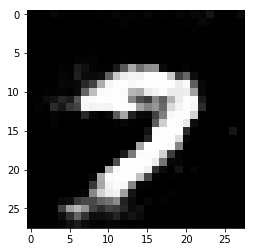

Epoch 2/2... Discriminator Loss: 1.1597... Generator Loss: 0.6900
Epoch 2/2... Discriminator Loss: 1.2336... Generator Loss: 0.6988
Epoch 2/2... Discriminator Loss: 1.3177... Generator Loss: 0.7444
Epoch 2/2... Discriminator Loss: 1.3341... Generator Loss: 0.6190
Epoch 2/2... Discriminator Loss: 1.4194... Generator Loss: 0.6526


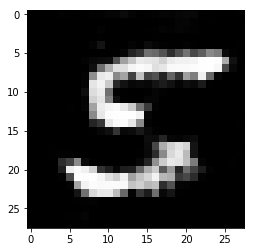

Epoch 2/2... Discriminator Loss: 1.5427... Generator Loss: 0.6539
Epoch 2/2... Discriminator Loss: 1.4152... Generator Loss: 0.7331
Epoch 2/2... Discriminator Loss: 1.3025... Generator Loss: 0.7319
Epoch 2/2... Discriminator Loss: 1.4195... Generator Loss: 0.6062
Epoch 2/2... Discriminator Loss: 1.1760... Generator Loss: 0.7949


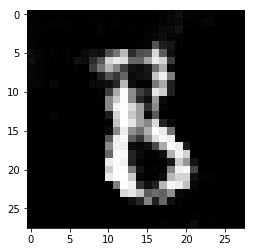

Epoch 2/2... Discriminator Loss: 1.0256... Generator Loss: 0.9167
Epoch 2/2... Discriminator Loss: 1.1066... Generator Loss: 0.8824
Epoch 2/2... Discriminator Loss: 1.4155... Generator Loss: 0.8251
Epoch 2/2... Discriminator Loss: 1.7366... Generator Loss: 0.4572
Epoch 2/2... Discriminator Loss: 1.5740... Generator Loss: 0.5442


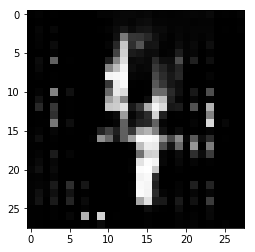

Epoch 2/2... Discriminator Loss: 1.3652... Generator Loss: 0.5755
Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 0.8854
Epoch 2/2... Discriminator Loss: 1.1390... Generator Loss: 0.7825
Epoch 2/2... Discriminator Loss: 1.3585... Generator Loss: 0.6844
Epoch 2/2... Discriminator Loss: 1.2401... Generator Loss: 0.7426


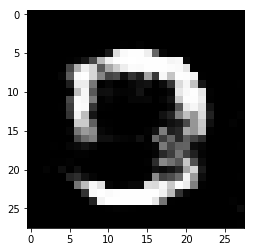

Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.7876
Epoch 2/2... Discriminator Loss: 1.2712... Generator Loss: 0.8169
Epoch 2/2... Discriminator Loss: 1.3775... Generator Loss: 0.6245
Epoch 2/2... Discriminator Loss: 1.3561... Generator Loss: 0.6852
Epoch 2/2... Discriminator Loss: 1.4263... Generator Loss: 0.4894


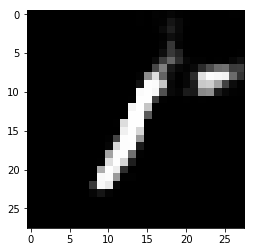

Epoch 2/2... Discriminator Loss: 1.3226... Generator Loss: 0.7385
Epoch 2/2... Discriminator Loss: 1.5364... Generator Loss: 0.5916
Epoch 2/2... Discriminator Loss: 1.3061... Generator Loss: 0.8545
Epoch 2/2... Discriminator Loss: 1.2666... Generator Loss: 0.6869
Epoch 2/2... Discriminator Loss: 1.2512... Generator Loss: 0.7173


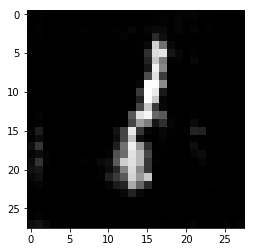

Epoch 2/2... Discriminator Loss: 1.3249... Generator Loss: 0.5789
Epoch 2/2... Discriminator Loss: 1.2490... Generator Loss: 0.7288
Epoch 2/2... Discriminator Loss: 1.2223... Generator Loss: 0.9283
Epoch 2/2... Discriminator Loss: 1.3826... Generator Loss: 0.6899
Epoch 2/2... Discriminator Loss: 1.5648... Generator Loss: 0.5320


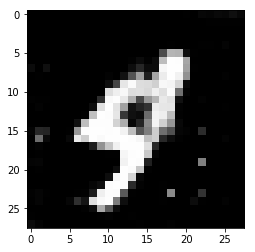

Epoch 2/2... Discriminator Loss: 1.5410... Generator Loss: 0.6260
Epoch 2/2... Discriminator Loss: 1.2968... Generator Loss: 0.6341
Epoch 2/2... Discriminator Loss: 1.2413... Generator Loss: 0.8040
Epoch 2/2... Discriminator Loss: 1.3545... Generator Loss: 0.7678
Epoch 2/2... Discriminator Loss: 1.2277... Generator Loss: 0.6211


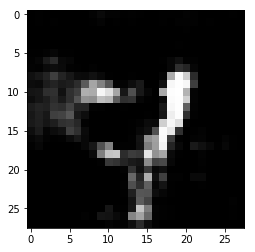

Epoch 2/2... Discriminator Loss: 1.6297... Generator Loss: 0.6627
Epoch 2/2... Discriminator Loss: 1.1218... Generator Loss: 0.7037
Epoch 2/2... Discriminator Loss: 1.4954... Generator Loss: 0.5870
Epoch 2/2... Discriminator Loss: 1.4525... Generator Loss: 0.8614
Epoch 2/2... Discriminator Loss: 1.3982... Generator Loss: 0.6826


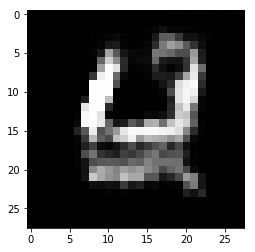

Epoch 2/2... Discriminator Loss: 1.6033... Generator Loss: 0.6291
Epoch 2/2... Discriminator Loss: 1.1699... Generator Loss: 0.7919
Epoch 2/2... Discriminator Loss: 1.3945... Generator Loss: 0.9343
Epoch 2/2... Discriminator Loss: 1.3793... Generator Loss: 0.6360
Epoch 2/2... Discriminator Loss: 1.1668... Generator Loss: 0.7268


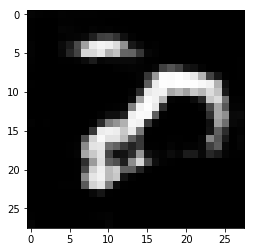

Epoch 2/2... Discriminator Loss: 1.4495... Generator Loss: 0.8125
Epoch 2/2... Discriminator Loss: 1.0142... Generator Loss: 0.8458
Epoch 2/2... Discriminator Loss: 1.2047... Generator Loss: 0.8023
Epoch 2/2... Discriminator Loss: 1.4628... Generator Loss: 0.4600
Epoch 2/2... Discriminator Loss: 1.4410... Generator Loss: 0.8402


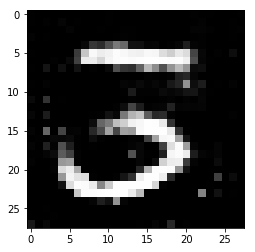

Epoch 2/2... Discriminator Loss: 1.3158... Generator Loss: 0.6372
Epoch 2/2... Discriminator Loss: 1.1735... Generator Loss: 0.7638
Epoch 2/2... Discriminator Loss: 1.4559... Generator Loss: 0.5537
Epoch 2/2... Discriminator Loss: 1.3887... Generator Loss: 0.7300
Epoch 2/2... Discriminator Loss: 1.0511... Generator Loss: 0.8881


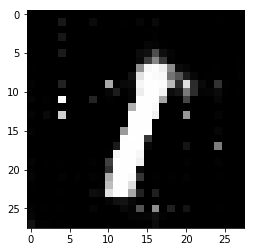

Epoch 2/2... Discriminator Loss: 1.2345... Generator Loss: 0.6649
Epoch 2/2... Discriminator Loss: 1.2756... Generator Loss: 0.7576
Epoch 2/2... Discriminator Loss: 1.1693... Generator Loss: 0.7825
Epoch 2/2... Discriminator Loss: 1.2100... Generator Loss: 0.7271
Epoch 2/2... Discriminator Loss: 1.2510... Generator Loss: 0.7304


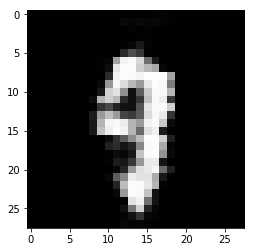

Epoch 2/2... Discriminator Loss: 1.3115... Generator Loss: 0.6622
Epoch 2/2... Discriminator Loss: 1.5969... Generator Loss: 0.5450
Epoch 2/2... Discriminator Loss: 1.4276... Generator Loss: 0.5663
Epoch 2/2... Discriminator Loss: 1.5787... Generator Loss: 0.5099
Epoch 2/2... Discriminator Loss: 1.2904... Generator Loss: 0.8726


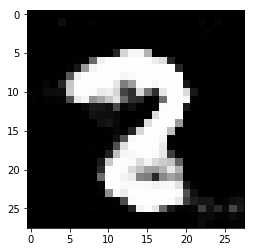

Epoch 2/2... Discriminator Loss: 1.3970... Generator Loss: 0.7310
Epoch 2/2... Discriminator Loss: 1.1598... Generator Loss: 0.7086
Epoch 2/2... Discriminator Loss: 1.3497... Generator Loss: 0.6245
Epoch 2/2... Discriminator Loss: 1.2696... Generator Loss: 0.7136
Epoch 2/2... Discriminator Loss: 1.4997... Generator Loss: 0.5718


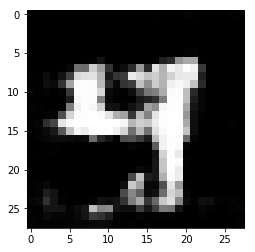

Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 0.7757
Epoch 2/2... Discriminator Loss: 1.2630... Generator Loss: 0.5710
Epoch 2/2... Discriminator Loss: 1.5135... Generator Loss: 0.6206
Epoch 2/2... Discriminator Loss: 1.6662... Generator Loss: 0.5984
Epoch 2/2... Discriminator Loss: 1.3102... Generator Loss: 0.7137


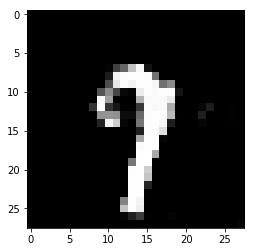

Epoch 2/2... Discriminator Loss: 1.5089... Generator Loss: 0.5573
Epoch 2/2... Discriminator Loss: 1.1734... Generator Loss: 0.9178
Epoch 2/2... Discriminator Loss: 0.9238... Generator Loss: 1.0016
Epoch 2/2... Discriminator Loss: 1.2932... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.4644... Generator Loss: 0.6700


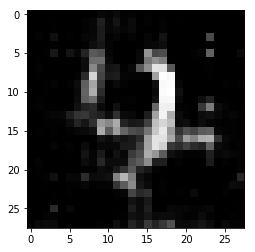

Epoch 2/2... Discriminator Loss: 1.0819... Generator Loss: 0.7784
Epoch 2/2... Discriminator Loss: 1.3468... Generator Loss: 0.5170
Epoch 2/2... Discriminator Loss: 1.2005... Generator Loss: 0.8552
Epoch 2/2... Discriminator Loss: 1.2559... Generator Loss: 0.8660
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.6685


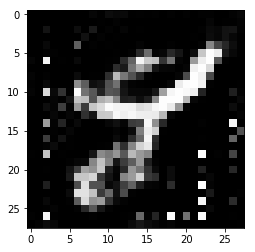

Epoch 2/2... Discriminator Loss: 1.2805... Generator Loss: 0.6809
Epoch 2/2... Discriminator Loss: 1.2720... Generator Loss: 0.6683
Epoch 2/2... Discriminator Loss: 1.2293... Generator Loss: 0.9357
Epoch 2/2... Discriminator Loss: 1.5615... Generator Loss: 0.6088
Epoch 2/2... Discriminator Loss: 1.2403... Generator Loss: 0.8144


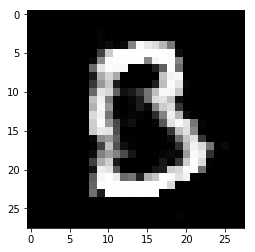

Epoch 2/2... Discriminator Loss: 1.2536... Generator Loss: 0.8851
Epoch 2/2... Discriminator Loss: 1.1193... Generator Loss: 0.8064
Epoch 2/2... Discriminator Loss: 1.4175... Generator Loss: 0.6385
Epoch 2/2... Discriminator Loss: 1.4097... Generator Loss: 0.5620
Epoch 2/2... Discriminator Loss: 1.1697... Generator Loss: 0.7304


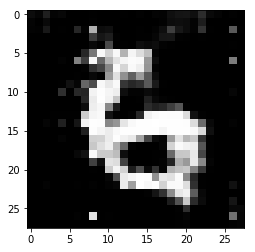

Epoch 2/2... Discriminator Loss: 1.4983... Generator Loss: 0.6344
Epoch 2/2... Discriminator Loss: 1.2486... Generator Loss: 0.8907
Epoch 2/2... Discriminator Loss: 1.5357... Generator Loss: 0.5794
Epoch 2/2... Discriminator Loss: 1.1791... Generator Loss: 0.9657
Epoch 2/2... Discriminator Loss: 1.4490... Generator Loss: 0.5526


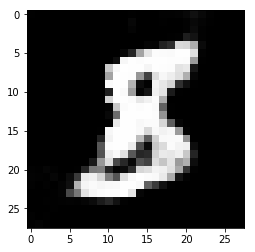

Epoch 2/2... Discriminator Loss: 1.0559... Generator Loss: 0.8587
Epoch 2/2... Discriminator Loss: 1.0328... Generator Loss: 0.9200
Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 0.7540
Epoch 2/2... Discriminator Loss: 1.2512... Generator Loss: 0.6330
Epoch 2/2... Discriminator Loss: 1.1747... Generator Loss: 0.7274


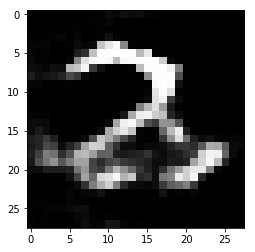

Epoch 2/2... Discriminator Loss: 1.3126... Generator Loss: 0.7674
Epoch 2/2... Discriminator Loss: 1.4233... Generator Loss: 0.8047
Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 0.7822
Epoch 2/2... Discriminator Loss: 1.3600... Generator Loss: 0.6331
Epoch 2/2... Discriminator Loss: 1.1207... Generator Loss: 0.7511


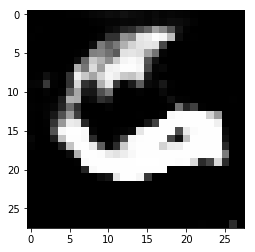

Epoch 2/2... Discriminator Loss: 1.0933... Generator Loss: 0.8882
Epoch 2/2... Discriminator Loss: 1.2923... Generator Loss: 0.9220
Epoch 2/2... Discriminator Loss: 1.6432... Generator Loss: 0.5229
Epoch 2/2... Discriminator Loss: 1.4095... Generator Loss: 0.6845
Epoch 2/2... Discriminator Loss: 1.1830... Generator Loss: 0.8221


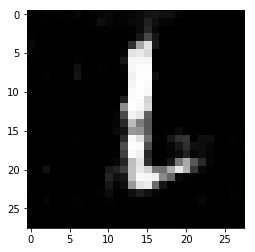

Epoch 2/2... Discriminator Loss: 1.2703... Generator Loss: 1.1386
Epoch 2/2... Discriminator Loss: 1.4313... Generator Loss: 0.6500
Epoch 2/2... Discriminator Loss: 1.3843... Generator Loss: 0.7263
Epoch 2/2... Discriminator Loss: 1.3149... Generator Loss: 0.6415
Epoch 2/2... Discriminator Loss: 1.2585... Generator Loss: 0.7570


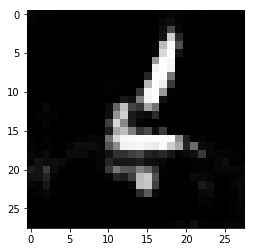

Epoch 2/2... Discriminator Loss: 1.2267... Generator Loss: 0.8229
Epoch 2/2... Discriminator Loss: 1.1645... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 1.3094... Generator Loss: 0.7509
Epoch 2/2... Discriminator Loss: 1.4213... Generator Loss: 0.8028
Epoch 2/2... Discriminator Loss: 1.2208... Generator Loss: 0.8715


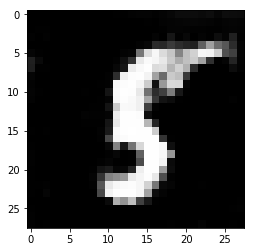

Epoch 2/2... Discriminator Loss: 1.3283... Generator Loss: 0.7056
Epoch 2/2... Discriminator Loss: 1.0748... Generator Loss: 1.2517
Epoch 2/2... Discriminator Loss: 1.2542... Generator Loss: 0.6759
Epoch 2/2... Discriminator Loss: 1.3264... Generator Loss: 0.6809
Epoch 2/2... Discriminator Loss: 1.3075... Generator Loss: 0.7204


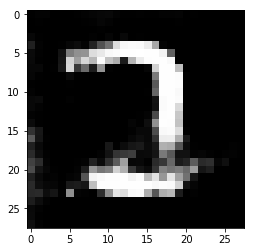

Epoch 2/2... Discriminator Loss: 1.1126... Generator Loss: 0.8167
Epoch 2/2... Discriminator Loss: 1.1784... Generator Loss: 0.8055
Epoch 2/2... Discriminator Loss: 1.1459... Generator Loss: 0.7076
Epoch 2/2... Discriminator Loss: 1.2874... Generator Loss: 0.7794
Epoch 2/2... Discriminator Loss: 1.4486... Generator Loss: 0.5659


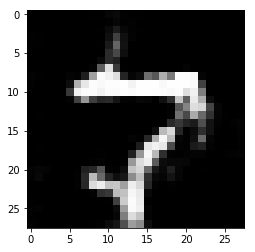

Epoch 2/2... Discriminator Loss: 1.2669... Generator Loss: 0.8126
Epoch 2/2... Discriminator Loss: 1.3242... Generator Loss: 0.6576
Epoch 2/2... Discriminator Loss: 1.5353... Generator Loss: 0.8363
Epoch 2/2... Discriminator Loss: 1.2674... Generator Loss: 0.6991
Epoch 2/2... Discriminator Loss: 1.4574... Generator Loss: 0.6962


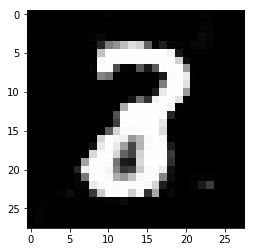

Epoch 2/2... Discriminator Loss: 1.2344... Generator Loss: 0.6556
Epoch 2/2... Discriminator Loss: 1.3590... Generator Loss: 0.8836
Epoch 2/2... Discriminator Loss: 1.4077... Generator Loss: 0.6499
Epoch 2/2... Discriminator Loss: 1.1427... Generator Loss: 0.7282
Epoch 2/2... Discriminator Loss: 1.4616... Generator Loss: 0.5826


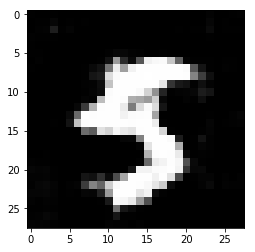

Epoch 2/2... Discriminator Loss: 1.3108... Generator Loss: 0.6839
Epoch 2/2... Discriminator Loss: 1.1874... Generator Loss: 0.9082
Epoch 2/2... Discriminator Loss: 1.3123... Generator Loss: 0.7296
Epoch 2/2... Discriminator Loss: 1.2152... Generator Loss: 0.8219
Epoch 2/2... Discriminator Loss: 1.1789... Generator Loss: 0.9663


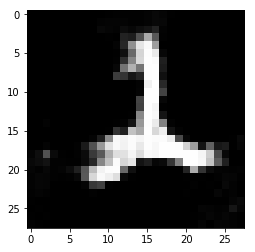

Epoch 2/2... Discriminator Loss: 1.5655... Generator Loss: 0.5979
Epoch 2/2... Discriminator Loss: 1.6106... Generator Loss: 0.6146
Epoch 2/2... Discriminator Loss: 1.1875... Generator Loss: 0.6276
Epoch 2/2... Discriminator Loss: 1.1122... Generator Loss: 0.7783
Epoch 2/2... Discriminator Loss: 1.4027... Generator Loss: 0.6878


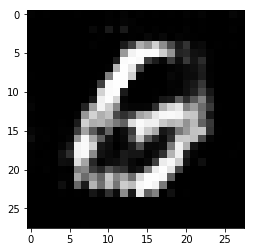

Epoch 2/2... Discriminator Loss: 1.4450... Generator Loss: 0.5356
Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 0.8249
Epoch 2/2... Discriminator Loss: 1.5061... Generator Loss: 0.5675
Epoch 2/2... Discriminator Loss: 1.3977... Generator Loss: 0.6075
Epoch 2/2... Discriminator Loss: 1.3780... Generator Loss: 0.6768


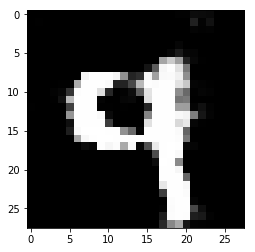

Epoch 2/2... Discriminator Loss: 1.3068... Generator Loss: 0.6498
Epoch 2/2... Discriminator Loss: 1.1615... Generator Loss: 0.6587
Epoch 2/2... Discriminator Loss: 1.5337... Generator Loss: 0.5527
Epoch 2/2... Discriminator Loss: 1.2426... Generator Loss: 0.6633
Epoch 2/2... Discriminator Loss: 1.2027... Generator Loss: 0.7747


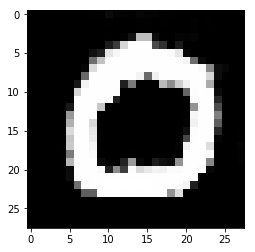

Epoch 2/2... Discriminator Loss: 1.4536... Generator Loss: 0.7286
Epoch 2/2... Discriminator Loss: 1.3396... Generator Loss: 0.7060
Epoch 2/2... Discriminator Loss: 1.3301... Generator Loss: 0.6455
Epoch 2/2... Discriminator Loss: 1.2105... Generator Loss: 0.5935
Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 0.7625


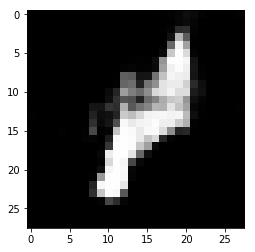

Epoch 2/2... Discriminator Loss: 1.3693... Generator Loss: 0.6302
Epoch 2/2... Discriminator Loss: 1.2162... Generator Loss: 0.7305
Epoch 2/2... Discriminator Loss: 1.0850... Generator Loss: 1.0126
Epoch 2/2... Discriminator Loss: 1.5326... Generator Loss: 0.5325
Epoch 2/2... Discriminator Loss: 1.3881... Generator Loss: 0.6460


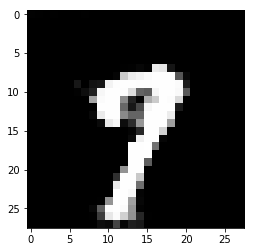

Epoch 2/2... Discriminator Loss: 1.4587... Generator Loss: 0.5801
Epoch 2/2... Discriminator Loss: 1.5572... Generator Loss: 0.5705
Epoch 2/2... Discriminator Loss: 1.1380... Generator Loss: 0.7448
Epoch 2/2... Discriminator Loss: 1.1454... Generator Loss: 0.7787
Epoch 2/2... Discriminator Loss: 1.3280... Generator Loss: 0.7827


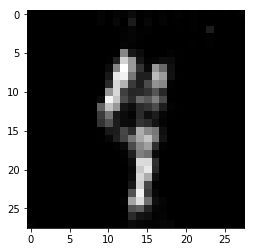

Epoch 2/2... Discriminator Loss: 1.1112... Generator Loss: 0.7609
Epoch 2/2... Discriminator Loss: 1.4046... Generator Loss: 0.5436
Epoch 2/2... Discriminator Loss: 1.3809... Generator Loss: 0.5837
Epoch 2/2... Discriminator Loss: 1.3705... Generator Loss: 0.8980
Epoch 2/2... Discriminator Loss: 1.2614... Generator Loss: 0.7551


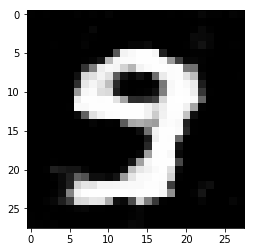

Epoch 2/2... Discriminator Loss: 1.0430... Generator Loss: 0.8050
Epoch 2/2... Discriminator Loss: 1.5092... Generator Loss: 0.6547
Epoch 2/2... Discriminator Loss: 1.1387... Generator Loss: 0.7233
Epoch 2/2... Discriminator Loss: 1.4453... Generator Loss: 0.6281
Epoch 2/2... Discriminator Loss: 1.4652... Generator Loss: 0.6890


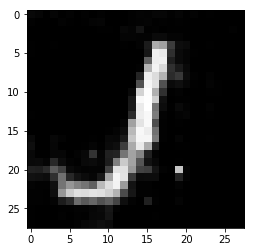

Epoch 2/2... Discriminator Loss: 1.4344... Generator Loss: 0.5608
Epoch 2/2... Discriminator Loss: 1.5074... Generator Loss: 0.6063
Epoch 2/2... Discriminator Loss: 1.1979... Generator Loss: 0.7392
Epoch 2/2... Discriminator Loss: 1.2163... Generator Loss: 0.7579
Epoch 2/2... Discriminator Loss: 1.4031... Generator Loss: 0.7212


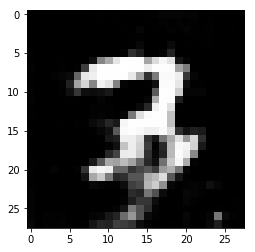

Epoch 2/2... Discriminator Loss: 1.2544... Generator Loss: 0.5996
Epoch 2/2... Discriminator Loss: 1.1661... Generator Loss: 0.8310
Epoch 2/2... Discriminator Loss: 1.1856... Generator Loss: 0.6784
Epoch 2/2... Discriminator Loss: 1.3225... Generator Loss: 0.6086
Epoch 2/2... Discriminator Loss: 1.4445... Generator Loss: 0.6449


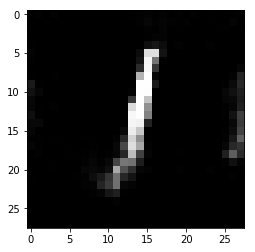

Epoch 2/2... Discriminator Loss: 1.4286... Generator Loss: 0.5820
Epoch 2/2... Discriminator Loss: 1.0269... Generator Loss: 0.9863
Epoch 2/2... Discriminator Loss: 1.0289... Generator Loss: 0.9482
Epoch 2/2... Discriminator Loss: 1.4727... Generator Loss: 0.6919
Epoch 2/2... Discriminator Loss: 1.3780... Generator Loss: 0.6705


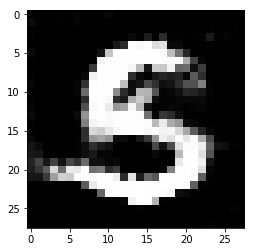

Epoch 2/2... Discriminator Loss: 1.6949... Generator Loss: 0.7097
Epoch 2/2... Discriminator Loss: 1.3952... Generator Loss: 0.5673
Epoch 2/2... Discriminator Loss: 1.1829... Generator Loss: 0.9366
Epoch 2/2... Discriminator Loss: 1.3496... Generator Loss: 0.6745
Epoch 2/2... Discriminator Loss: 1.2532... Generator Loss: 0.6527


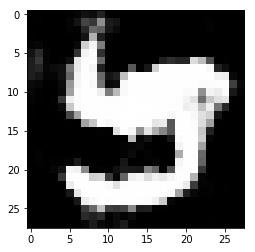

Epoch 2/2... Discriminator Loss: 1.2049... Generator Loss: 0.8460
Epoch 2/2... Discriminator Loss: 1.7507... Generator Loss: 0.4239
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.7307
Epoch 2/2... Discriminator Loss: 1.1913... Generator Loss: 0.6886
Epoch 2/2... Discriminator Loss: 1.2678... Generator Loss: 0.6761


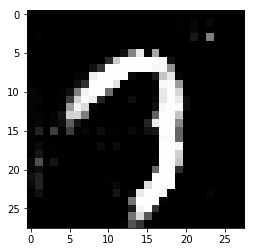

Epoch 2/2... Discriminator Loss: 1.3211... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 1.4219... Generator Loss: 0.6277
Epoch 2/2... Discriminator Loss: 1.3151... Generator Loss: 0.7254
Epoch 2/2... Discriminator Loss: 1.2460... Generator Loss: 0.7420
Epoch 2/2... Discriminator Loss: 1.1960... Generator Loss: 0.6787


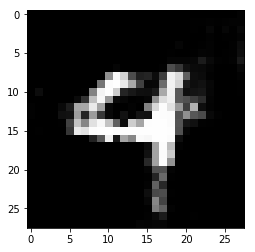

Epoch 2/2... Discriminator Loss: 1.5303... Generator Loss: 0.5349
Epoch 2/2... Discriminator Loss: 1.1404... Generator Loss: 0.7746
Epoch 2/2... Discriminator Loss: 1.2312... Generator Loss: 0.6673
Epoch 2/2... Discriminator Loss: 1.6832... Generator Loss: 0.4875
Epoch 2/2... Discriminator Loss: 1.5235... Generator Loss: 0.7583


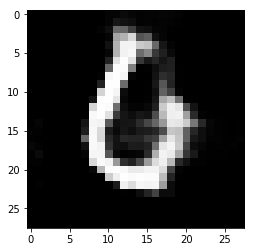

Epoch 2/2... Discriminator Loss: 1.3288... Generator Loss: 0.5834
Epoch 2/2... Discriminator Loss: 1.4304... Generator Loss: 0.7405
Epoch 2/2... Discriminator Loss: 1.2923... Generator Loss: 0.6627
Epoch 2/2... Discriminator Loss: 1.2702... Generator Loss: 0.7763
Epoch 2/2... Discriminator Loss: 1.1427... Generator Loss: 0.8918


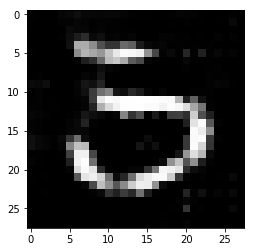

Epoch 2/2... Discriminator Loss: 1.4201... Generator Loss: 0.6602
Epoch 2/2... Discriminator Loss: 1.3602... Generator Loss: 0.6989
Epoch 2/2... Discriminator Loss: 1.3516... Generator Loss: 0.6911
Epoch 2/2... Discriminator Loss: 1.2218... Generator Loss: 0.7072
Epoch 2/2... Discriminator Loss: 1.1929... Generator Loss: 0.7288


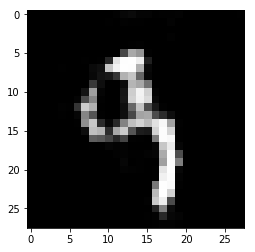

Epoch 2/2... Discriminator Loss: 1.2557... Generator Loss: 0.7550
Epoch 2/2... Discriminator Loss: 1.4312... Generator Loss: 0.6462
Epoch 2/2... Discriminator Loss: 1.2066... Generator Loss: 0.7000
Epoch 2/2... Discriminator Loss: 1.3260... Generator Loss: 0.6768
Epoch 2/2... Discriminator Loss: 1.5324... Generator Loss: 0.5586


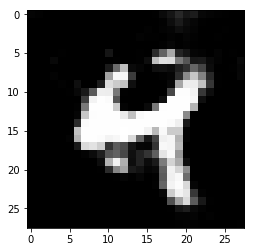

Epoch 2/2... Discriminator Loss: 1.3794... Generator Loss: 0.6520
Epoch 2/2... Discriminator Loss: 1.4430... Generator Loss: 0.5915
Epoch 2/2... Discriminator Loss: 1.4171... Generator Loss: 0.5536
Epoch 2/2... Discriminator Loss: 1.1608... Generator Loss: 0.7766
Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.6698


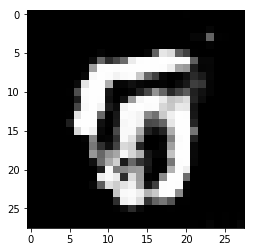

Epoch 2/2... Discriminator Loss: 1.0483... Generator Loss: 0.9167
Epoch 2/2... Discriminator Loss: 1.6675... Generator Loss: 0.5679
Epoch 2/2... Discriminator Loss: 1.4669... Generator Loss: 0.6655
Epoch 2/2... Discriminator Loss: 1.5101... Generator Loss: 0.4716
Epoch 2/2... Discriminator Loss: 1.1748... Generator Loss: 0.7317


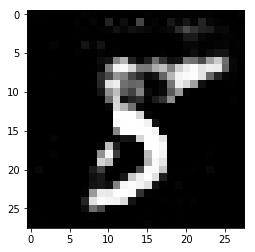

Epoch 2/2... Discriminator Loss: 1.2955... Generator Loss: 0.7412
Epoch 2/2... Discriminator Loss: 1.6971... Generator Loss: 0.6356
Epoch 2/2... Discriminator Loss: 1.2114... Generator Loss: 0.7516
Epoch 2/2... Discriminator Loss: 1.5553... Generator Loss: 0.5572
Epoch 2/2... Discriminator Loss: 1.1331... Generator Loss: 0.8043


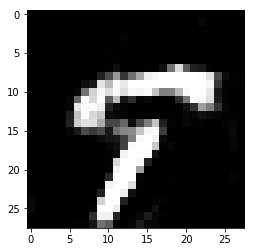

Epoch 2/2... Discriminator Loss: 1.2198... Generator Loss: 0.6779
Epoch 2/2... Discriminator Loss: 1.1612... Generator Loss: 0.7864
Epoch 2/2... Discriminator Loss: 1.5243... Generator Loss: 0.5199
Epoch 2/2... Discriminator Loss: 1.2213... Generator Loss: 0.7673
Epoch 2/2... Discriminator Loss: 1.3804... Generator Loss: 0.5836


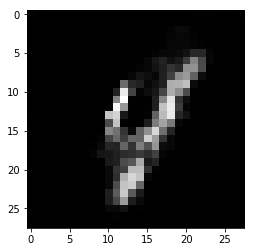

Epoch 2/2... Discriminator Loss: 1.4642... Generator Loss: 0.7567
Epoch 2/2... Discriminator Loss: 1.2411... Generator Loss: 0.7278
Epoch 2/2... Discriminator Loss: 1.3630... Generator Loss: 0.6635
Epoch 2/2... Discriminator Loss: 1.2341... Generator Loss: 0.9637
Epoch 2/2... Discriminator Loss: 1.1721... Generator Loss: 0.8321


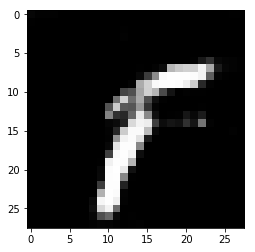

Epoch 2/2... Discriminator Loss: 1.1889... Generator Loss: 0.8157
Epoch 2/2... Discriminator Loss: 1.6070... Generator Loss: 0.5558
Epoch 2/2... Discriminator Loss: 1.2179... Generator Loss: 0.7625
Epoch 2/2... Discriminator Loss: 1.4874... Generator Loss: 0.5604
Epoch 2/2... Discriminator Loss: 1.0668... Generator Loss: 0.8172


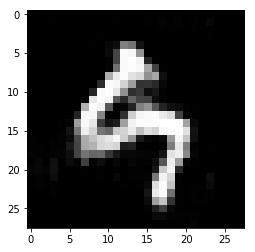

Epoch 2/2... Discriminator Loss: 1.3309... Generator Loss: 0.7033
Epoch 2/2... Discriminator Loss: 1.2435... Generator Loss: 0.7210
Epoch 2/2... Discriminator Loss: 1.2574... Generator Loss: 0.7881
Epoch 2/2... Discriminator Loss: 1.1767... Generator Loss: 0.6580
Epoch 2/2... Discriminator Loss: 1.2055... Generator Loss: 0.7410


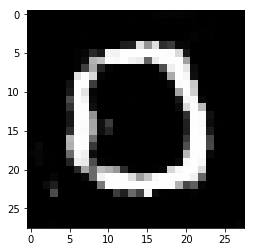

Epoch 2/2... Discriminator Loss: 1.4524... Generator Loss: 0.7419
Epoch 2/2... Discriminator Loss: 1.2795... Generator Loss: 0.7162
Epoch 2/2... Discriminator Loss: 1.3485... Generator Loss: 0.7451
Epoch 2/2... Discriminator Loss: 1.4662... Generator Loss: 0.5613
Epoch 2/2... Discriminator Loss: 1.3890... Generator Loss: 0.7197


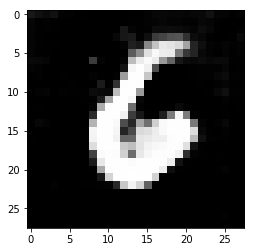

Epoch 2/2... Discriminator Loss: 1.2333... Generator Loss: 0.6642
Epoch 2/2... Discriminator Loss: 1.3047... Generator Loss: 0.7775
Epoch 2/2... Discriminator Loss: 1.1880... Generator Loss: 0.7043
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.6695
Epoch 2/2... Discriminator Loss: 1.5126... Generator Loss: 0.5793


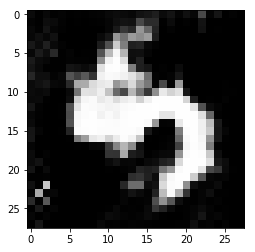

Epoch 2/2... Discriminator Loss: 1.2774... Generator Loss: 0.7002
Epoch 2/2... Discriminator Loss: 1.3147... Generator Loss: 0.7133
Epoch 2/2... Discriminator Loss: 1.4431... Generator Loss: 0.6331
Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 0.7030
Epoch 2/2... Discriminator Loss: 1.3525... Generator Loss: 0.6804


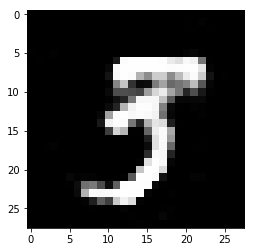

Epoch 2/2... Discriminator Loss: 1.1163... Generator Loss: 0.9573
Epoch 2/2... Discriminator Loss: 1.1956... Generator Loss: 0.7906
Epoch 2/2... Discriminator Loss: 1.2534... Generator Loss: 0.7018
Epoch 2/2... Discriminator Loss: 1.6530... Generator Loss: 0.5536
Epoch 2/2... Discriminator Loss: 1.7362... Generator Loss: 0.4238


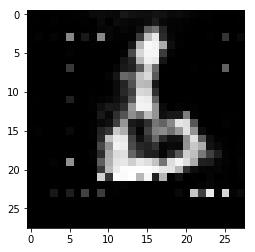

Epoch 2/2... Discriminator Loss: 1.3074... Generator Loss: 0.6270
Epoch 2/2... Discriminator Loss: 1.2772... Generator Loss: 0.7327
Epoch 2/2... Discriminator Loss: 1.3953... Generator Loss: 0.7549
Epoch 2/2... Discriminator Loss: 1.2182... Generator Loss: 0.7501
Epoch 2/2... Discriminator Loss: 1.2668... Generator Loss: 0.7891


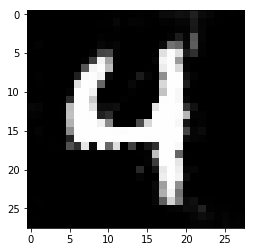

Epoch 2/2... Discriminator Loss: 1.4046... Generator Loss: 0.7918
Epoch 2/2... Discriminator Loss: 1.3462... Generator Loss: 0.5420
Epoch 2/2... Discriminator Loss: 1.2971... Generator Loss: 0.6212
Epoch 2/2... Discriminator Loss: 1.1072... Generator Loss: 0.9788
Epoch 2/2... Discriminator Loss: 1.1239... Generator Loss: 0.7043


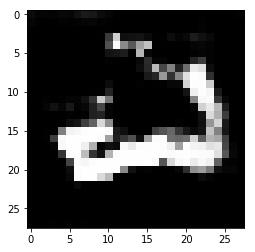

Epoch 2/2... Discriminator Loss: 1.6181... Generator Loss: 0.6374
Epoch 2/2... Discriminator Loss: 1.4406... Generator Loss: 0.6159
Epoch 2/2... Discriminator Loss: 1.6227... Generator Loss: 0.5070
Epoch 2/2... Discriminator Loss: 1.3412... Generator Loss: 0.5925
Epoch 2/2... Discriminator Loss: 1.2988... Generator Loss: 0.7494


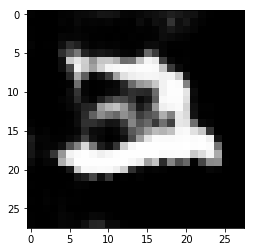

Epoch 2/2... Discriminator Loss: 1.2644... Generator Loss: 0.7723
Epoch 2/2... Discriminator Loss: 1.2681... Generator Loss: 0.7319
Epoch 2/2... Discriminator Loss: 1.0603... Generator Loss: 0.9798
Epoch 2/2... Discriminator Loss: 1.3519... Generator Loss: 0.6800
Epoch 2/2... Discriminator Loss: 1.2887... Generator Loss: 0.7054


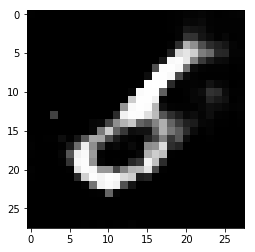

Epoch 2/2... Discriminator Loss: 1.2485... Generator Loss: 0.7776
Epoch 2/2... Discriminator Loss: 1.1654... Generator Loss: 0.7835
Epoch 2/2... Discriminator Loss: 1.2850... Generator Loss: 0.6676
Epoch 2/2... Discriminator Loss: 1.3398... Generator Loss: 0.6235
Epoch 2/2... Discriminator Loss: 1.0556... Generator Loss: 0.9150


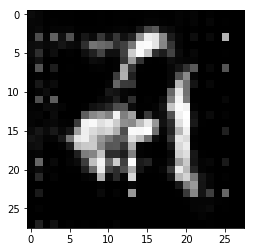

Epoch 2/2... Discriminator Loss: 1.0029... Generator Loss: 0.9301
Epoch 2/2... Discriminator Loss: 1.4924... Generator Loss: 0.4999
Epoch 2/2... Discriminator Loss: 1.2366... Generator Loss: 0.8114
Epoch 2/2... Discriminator Loss: 1.4989... Generator Loss: 0.6212
Epoch 2/2... Discriminator Loss: 1.2282... Generator Loss: 0.7882


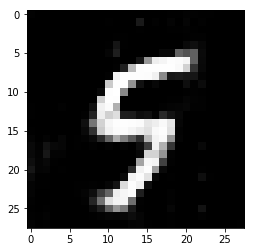

Epoch 2/2... Discriminator Loss: 1.4474... Generator Loss: 0.5548
Epoch 2/2... Discriminator Loss: 1.3476... Generator Loss: 0.6586
Epoch 2/2... Discriminator Loss: 1.2003... Generator Loss: 0.8691
Epoch 2/2... Discriminator Loss: 1.1888... Generator Loss: 0.8961
Epoch 2/2... Discriminator Loss: 1.2032... Generator Loss: 0.7121


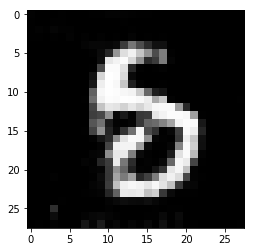

Epoch 2/2... Discriminator Loss: 1.0440... Generator Loss: 0.8922
Epoch 2/2... Discriminator Loss: 1.3375... Generator Loss: 0.6772
Epoch 2/2... Discriminator Loss: 1.1249... Generator Loss: 0.9193
Epoch 2/2... Discriminator Loss: 1.2512... Generator Loss: 0.7111
Epoch 2/2... Discriminator Loss: 1.4162... Generator Loss: 0.7713


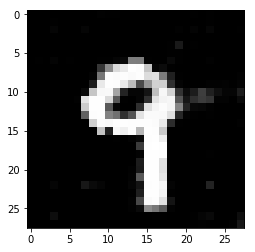

Epoch 2/2... Discriminator Loss: 1.2090... Generator Loss: 0.7194
Epoch 2/2... Discriminator Loss: 1.4789... Generator Loss: 0.6181
Epoch 2/2... Discriminator Loss: 1.3723... Generator Loss: 0.6338
Epoch 2/2... Discriminator Loss: 1.1469... Generator Loss: 0.8225
Epoch 2/2... Discriminator Loss: 1.3477... Generator Loss: 0.6494


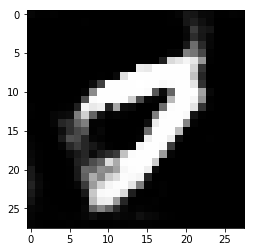

Epoch 2/2... Discriminator Loss: 1.4125... Generator Loss: 0.6124
Epoch 2/2... Discriminator Loss: 1.1350... Generator Loss: 0.9633
Epoch 2/2... Discriminator Loss: 1.5060... Generator Loss: 0.5731
Epoch 2/2... Discriminator Loss: 1.2759... Generator Loss: 0.8358
Epoch 2/2... Discriminator Loss: 1.5255... Generator Loss: 0.6467


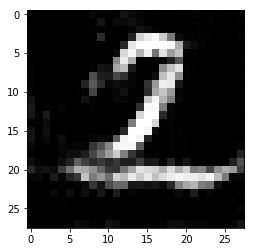

Epoch 2/2... Discriminator Loss: 1.0556... Generator Loss: 0.7517
Epoch 2/2... Discriminator Loss: 1.1792... Generator Loss: 0.7476
Epoch 2/2... Discriminator Loss: 1.4444... Generator Loss: 0.5600
Epoch 2/2... Discriminator Loss: 0.9619... Generator Loss: 0.9107
Epoch 2/2... Discriminator Loss: 1.4137... Generator Loss: 0.6471


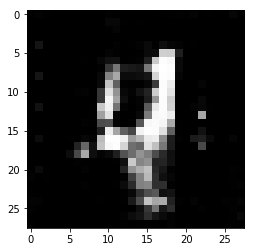

Epoch 2/2... Discriminator Loss: 1.4488... Generator Loss: 0.5466
Epoch 2/2... Discriminator Loss: 1.1884... Generator Loss: 0.8502
Epoch 2/2... Discriminator Loss: 1.1441... Generator Loss: 0.8352
Epoch 2/2... Discriminator Loss: 1.4162... Generator Loss: 0.6714
Epoch 2/2... Discriminator Loss: 1.2669... Generator Loss: 0.6951


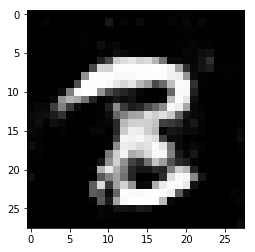

Epoch 2/2... Discriminator Loss: 1.4668... Generator Loss: 0.6330
Epoch 2/2... Discriminator Loss: 1.3734... Generator Loss: 0.6221
Epoch 2/2... Discriminator Loss: 1.2510... Generator Loss: 0.6783
Epoch 2/2... Discriminator Loss: 1.2192... Generator Loss: 0.6662
Epoch 2/2... Discriminator Loss: 1.3214... Generator Loss: 0.8998


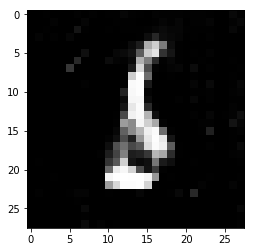

Epoch 2/2... Discriminator Loss: 1.3925... Generator Loss: 0.7242
Epoch 2/2... Discriminator Loss: 1.5497... Generator Loss: 0.5306
Epoch 2/2... Discriminator Loss: 1.3983... Generator Loss: 0.5725
Epoch 2/2... Discriminator Loss: 1.2983... Generator Loss: 0.7078
Epoch 2/2... Discriminator Loss: 1.2525... Generator Loss: 0.8868


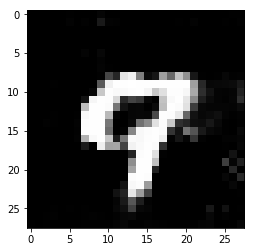

Epoch 2/2... Discriminator Loss: 1.0682... Generator Loss: 0.9699
Epoch 2/2... Discriminator Loss: 1.4761... Generator Loss: 0.6222
Epoch 2/2... Discriminator Loss: 1.2969... Generator Loss: 0.6565
Epoch 2/2... Discriminator Loss: 1.2726... Generator Loss: 0.6689
Epoch 2/2... Discriminator Loss: 1.2950... Generator Loss: 0.6833


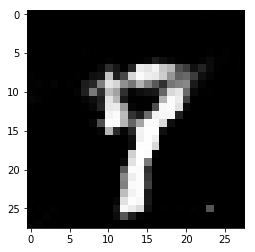

Epoch 2/2... Discriminator Loss: 1.3704... Generator Loss: 0.6438
Epoch 2/2... Discriminator Loss: 1.3282... Generator Loss: 0.6505
Epoch 2/2... Discriminator Loss: 1.3131... Generator Loss: 0.6088
Epoch 2/2... Discriminator Loss: 1.5338... Generator Loss: 0.4926
Epoch 2/2... Discriminator Loss: 1.4736... Generator Loss: 0.6559


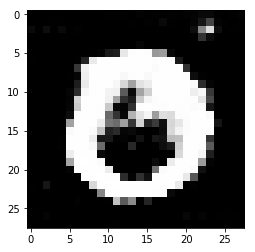

Epoch 2/2... Discriminator Loss: 1.1810... Generator Loss: 0.8963
Epoch 2/2... Discriminator Loss: 1.4604... Generator Loss: 0.6083
Epoch 2/2... Discriminator Loss: 1.2679... Generator Loss: 0.9349
Epoch 2/2... Discriminator Loss: 1.2943... Generator Loss: 0.7174
Epoch 2/2... Discriminator Loss: 1.2387... Generator Loss: 0.7509


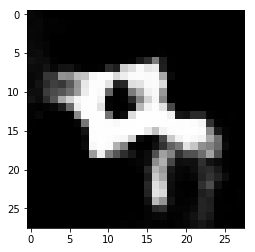

Epoch 2/2... Discriminator Loss: 1.3762... Generator Loss: 0.6155
Epoch 2/2... Discriminator Loss: 1.4866... Generator Loss: 0.7072
Epoch 2/2... Discriminator Loss: 1.3104... Generator Loss: 0.7501
Epoch 2/2... Discriminator Loss: 1.1998... Generator Loss: 0.8882
Epoch 2/2... Discriminator Loss: 1.4024... Generator Loss: 0.7107


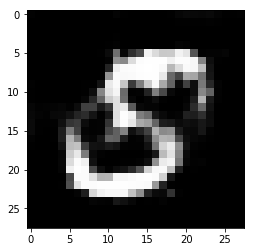

Epoch 2/2... Discriminator Loss: 1.2667... Generator Loss: 0.6688
Epoch 2/2... Discriminator Loss: 1.2868... Generator Loss: 0.7652
Epoch 2/2... Discriminator Loss: 1.2858... Generator Loss: 0.6491
Epoch 2/2... Discriminator Loss: 1.4163... Generator Loss: 0.6565
Epoch 2/2... Discriminator Loss: 1.2977... Generator Loss: 0.9103


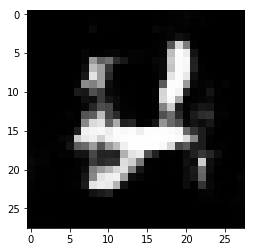

Epoch 2/2... Discriminator Loss: 1.3168... Generator Loss: 0.6878
Epoch 2/2... Discriminator Loss: 1.2782... Generator Loss: 0.8453
Epoch 2/2... Discriminator Loss: 1.3537... Generator Loss: 0.7316
Epoch 2/2... Discriminator Loss: 1.5266... Generator Loss: 0.5585
Epoch 2/2... Discriminator Loss: 1.2212... Generator Loss: 0.7174


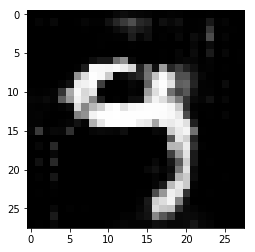

Epoch 2/2... Discriminator Loss: 1.2746... Generator Loss: 0.6158
Epoch 2/2... Discriminator Loss: 1.3490... Generator Loss: 0.5998
Epoch 2/2... Discriminator Loss: 1.2020... Generator Loss: 0.6968
Epoch 2/2... Discriminator Loss: 1.2366... Generator Loss: 0.7905
Epoch 2/2... Discriminator Loss: 1.4585... Generator Loss: 0.6310


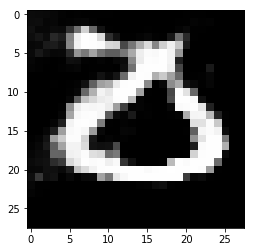

Epoch 2/2... Discriminator Loss: 1.2485... Generator Loss: 0.8198
Epoch 2/2... Discriminator Loss: 1.2467... Generator Loss: 0.6451
Epoch 2/2... Discriminator Loss: 1.2469... Generator Loss: 0.7796
Epoch 2/2... Discriminator Loss: 1.4269... Generator Loss: 0.6113
Epoch 2/2... Discriminator Loss: 1.2759... Generator Loss: 0.8262


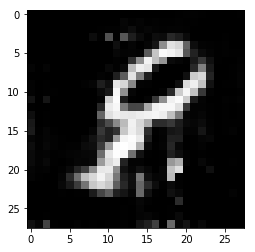

Epoch 2/2... Discriminator Loss: 1.3807... Generator Loss: 0.6515
Epoch 2/2... Discriminator Loss: 1.3387... Generator Loss: 0.6791
Epoch 2/2... Discriminator Loss: 1.3484... Generator Loss: 0.6915
Epoch 2/2... Discriminator Loss: 1.4803... Generator Loss: 0.5674
Epoch 2/2... Discriminator Loss: 1.1013... Generator Loss: 0.8386


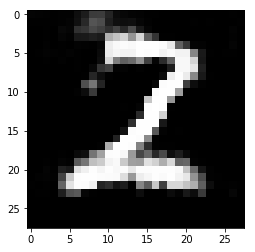

Epoch 2/2... Discriminator Loss: 1.1879... Generator Loss: 0.7757
Epoch 2/2... Discriminator Loss: 1.2561... Generator Loss: 0.7000
Epoch 2/2... Discriminator Loss: 1.3137... Generator Loss: 0.7539
Epoch 2/2... Discriminator Loss: 1.3316... Generator Loss: 0.7401
Epoch 2/2... Discriminator Loss: 1.4275... Generator Loss: 0.5666


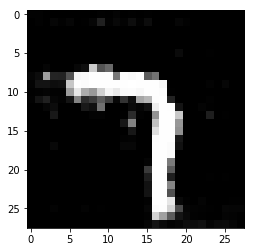

Epoch 2/2... Discriminator Loss: 1.3046... Generator Loss: 0.6945
Epoch 2/2... Discriminator Loss: 1.4567... Generator Loss: 0.6731
Epoch 2/2... Discriminator Loss: 1.1970... Generator Loss: 0.7429
Epoch 2/2... Discriminator Loss: 1.2929... Generator Loss: 0.7152
Epoch 2/2... Discriminator Loss: 1.5681... Generator Loss: 0.5412


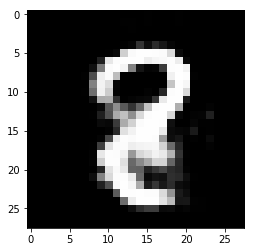

Epoch 2/2... Discriminator Loss: 1.1947... Generator Loss: 0.9195
Epoch 2/2... Discriminator Loss: 1.3976... Generator Loss: 0.6555
Epoch 2/2... Discriminator Loss: 1.2824... Generator Loss: 0.6475
Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.8340
Epoch 2/2... Discriminator Loss: 1.1734... Generator Loss: 0.7562


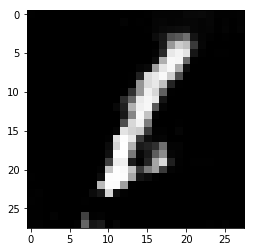

Epoch 2/2... Discriminator Loss: 1.4169... Generator Loss: 0.7331
Epoch 2/2... Discriminator Loss: 1.2625... Generator Loss: 0.6597
Epoch 2/2... Discriminator Loss: 1.2486... Generator Loss: 0.8279
Epoch 2/2... Discriminator Loss: 1.4060... Generator Loss: 0.5112
Epoch 2/2... Discriminator Loss: 1.2026... Generator Loss: 0.6768


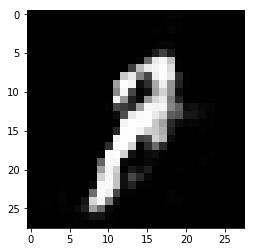

Epoch 2/2... Discriminator Loss: 1.2953... Generator Loss: 0.7102
Epoch 2/2... Discriminator Loss: 1.3657... Generator Loss: 0.6759
Epoch 2/2... Discriminator Loss: 1.1568... Generator Loss: 0.7488
Epoch 2/2... Discriminator Loss: 1.4229... Generator Loss: 0.7058
Epoch 2/2... Discriminator Loss: 1.5124... Generator Loss: 0.5546


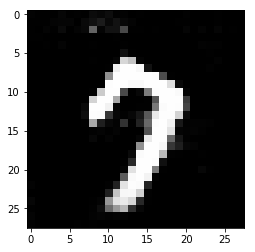

Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.6918
Epoch 2/2... Discriminator Loss: 1.3349... Generator Loss: 0.7127
Epoch 2/2... Discriminator Loss: 1.3044... Generator Loss: 0.6707
Epoch 2/2... Discriminator Loss: 1.3384... Generator Loss: 0.7185
Epoch 2/2... Discriminator Loss: 1.3548... Generator Loss: 0.6908


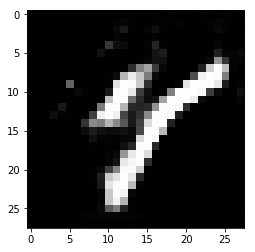

Epoch 2/2... Discriminator Loss: 1.1014... Generator Loss: 0.7879
Epoch 2/2... Discriminator Loss: 1.3986... Generator Loss: 0.6465
Epoch 2/2... Discriminator Loss: 1.2908... Generator Loss: 0.7831
Epoch 2/2... Discriminator Loss: 1.2000... Generator Loss: 0.7354
Epoch 2/2... Discriminator Loss: 1.3247... Generator Loss: 0.7669


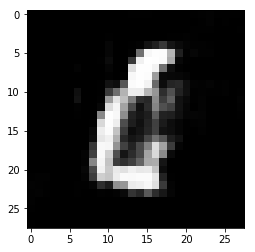

Epoch 2/2... Discriminator Loss: 1.2364... Generator Loss: 0.8212
Epoch 2/2... Discriminator Loss: 1.4076... Generator Loss: 0.7819
Epoch 2/2... Discriminator Loss: 1.2911... Generator Loss: 0.7127
Epoch 2/2... Discriminator Loss: 1.1539... Generator Loss: 0.7971
Epoch 2/2... Discriminator Loss: 1.2638... Generator Loss: 0.6637


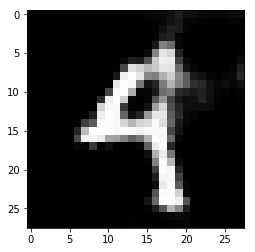

Epoch 2/2... Discriminator Loss: 1.3005... Generator Loss: 0.6443
Epoch 2/2... Discriminator Loss: 1.2805... Generator Loss: 0.7339
Epoch 2/2... Discriminator Loss: 1.4133... Generator Loss: 0.6078
Epoch 2/2... Discriminator Loss: 1.2062... Generator Loss: 0.7993
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.6193


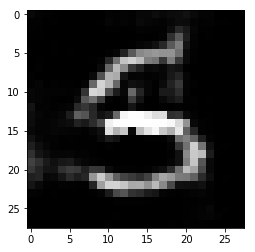

Epoch 2/2... Discriminator Loss: 1.4436... Generator Loss: 0.5859
Epoch 2/2... Discriminator Loss: 1.2280... Generator Loss: 0.8244
Epoch 2/2... Discriminator Loss: 1.3134... Generator Loss: 0.8700
Epoch 2/2... Discriminator Loss: 1.2050... Generator Loss: 0.8665
Epoch 2/2... Discriminator Loss: 1.3910... Generator Loss: 0.7560


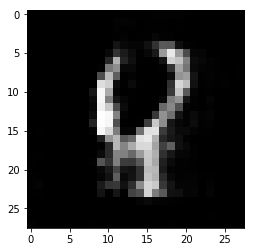

Epoch 2/2... Discriminator Loss: 1.6414... Generator Loss: 0.4571
Epoch 2/2... Discriminator Loss: 1.4154... Generator Loss: 0.6546
Epoch 2/2... Discriminator Loss: 1.2772... Generator Loss: 0.7282
Epoch 2/2... Discriminator Loss: 1.2700... Generator Loss: 0.7208
Epoch 2/2... Discriminator Loss: 1.3478... Generator Loss: 0.7625


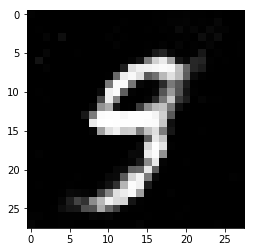

Epoch 2/2... Discriminator Loss: 1.4695... Generator Loss: 0.6495
Epoch 2/2... Discriminator Loss: 1.4708... Generator Loss: 0.5941
Epoch 2/2... Discriminator Loss: 1.4710... Generator Loss: 0.5808
Epoch 2/2... Discriminator Loss: 1.1481... Generator Loss: 0.7234
Epoch 2/2... Discriminator Loss: 1.2107... Generator Loss: 0.7127


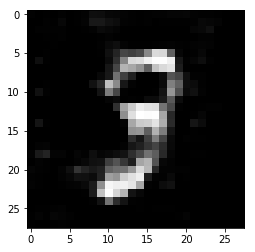

Epoch 2/2... Discriminator Loss: 1.4672... Generator Loss: 0.7112
Epoch 2/2... Discriminator Loss: 1.1984... Generator Loss: 0.8412
Epoch 2/2... Discriminator Loss: 1.3938... Generator Loss: 0.8582
Epoch 2/2... Discriminator Loss: 1.2667... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 1.5031... Generator Loss: 0.6322


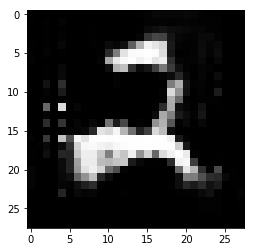

Epoch 2/2... Discriminator Loss: 1.2837... Generator Loss: 0.5989
Epoch 2/2... Discriminator Loss: 1.1656... Generator Loss: 0.7739
Epoch 2/2... Discriminator Loss: 1.3796... Generator Loss: 0.5774
Epoch 2/2... Discriminator Loss: 1.1163... Generator Loss: 0.7285
Epoch 2/2... Discriminator Loss: 1.2125... Generator Loss: 0.7654


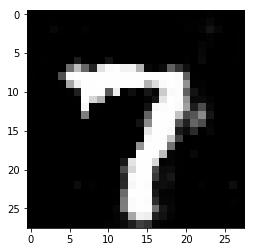

Epoch 2/2... Discriminator Loss: 1.1920... Generator Loss: 0.6589
Epoch 2/2... Discriminator Loss: 1.3547... Generator Loss: 0.7420
Epoch 2/2... Discriminator Loss: 1.4383... Generator Loss: 0.7386
Epoch 2/2... Discriminator Loss: 1.2050... Generator Loss: 0.7657
Epoch 2/2... Discriminator Loss: 1.3904... Generator Loss: 0.6829


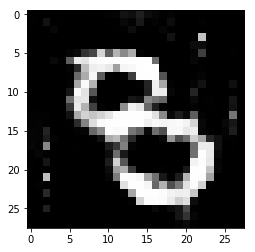

Epoch 2/2... Discriminator Loss: 1.2640... Generator Loss: 0.7470
Epoch 2/2... Discriminator Loss: 1.5565... Generator Loss: 0.5532
Epoch 2/2... Discriminator Loss: 1.1733... Generator Loss: 0.8711
Epoch 2/2... Discriminator Loss: 1.2204... Generator Loss: 0.7140
Epoch 2/2... Discriminator Loss: 1.3724... Generator Loss: 0.7439


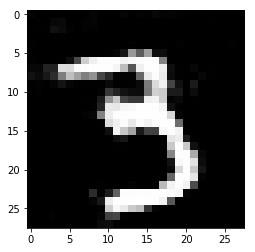

Epoch 2/2... Discriminator Loss: 1.2682... Generator Loss: 0.7739
Epoch 2/2... Discriminator Loss: 1.5304... Generator Loss: 0.6861
Epoch 2/2... Discriminator Loss: 1.3302... Generator Loss: 0.8294
Epoch 2/2... Discriminator Loss: 1.2089... Generator Loss: 0.6088
Epoch 2/2... Discriminator Loss: 1.2857... Generator Loss: 0.6296


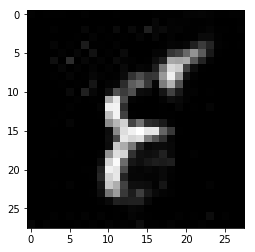

Epoch 2/2... Discriminator Loss: 1.4237... Generator Loss: 0.6983
Epoch 2/2... Discriminator Loss: 1.1973... Generator Loss: 0.7824
Epoch 2/2... Discriminator Loss: 1.4243... Generator Loss: 0.6216
Epoch 2/2... Discriminator Loss: 1.3463... Generator Loss: 0.6567
Epoch 2/2... Discriminator Loss: 1.1631... Generator Loss: 0.7778


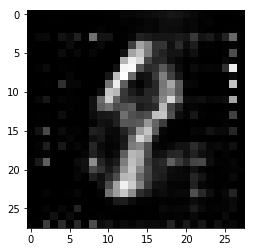

Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.7686
Epoch 2/2... Discriminator Loss: 1.2875... Generator Loss: 0.6793
Epoch 2/2... Discriminator Loss: 0.8910... Generator Loss: 1.0027
Epoch 2/2... Discriminator Loss: 1.4195... Generator Loss: 0.7076
Epoch 2/2... Discriminator Loss: 1.3277... Generator Loss: 0.8414


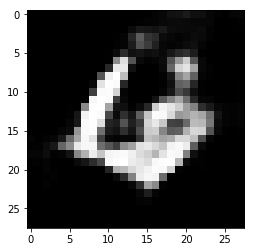

Epoch 2/2... Discriminator Loss: 1.5042... Generator Loss: 0.6170
Epoch 2/2... Discriminator Loss: 1.2039... Generator Loss: 0.8537
Epoch 2/2... Discriminator Loss: 1.3213... Generator Loss: 0.7999
Epoch 2/2... Discriminator Loss: 1.3061... Generator Loss: 0.8007
Epoch 2/2... Discriminator Loss: 1.2608... Generator Loss: 0.5302


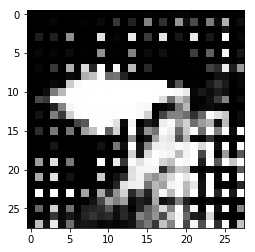

Epoch 2/2... Discriminator Loss: 0.9484... Generator Loss: 1.0132
Epoch 2/2... Discriminator Loss: 1.6603... Generator Loss: 0.7551
Epoch 2/2... Discriminator Loss: 1.4658... Generator Loss: 0.7619
Epoch 2/2... Discriminator Loss: 1.3082... Generator Loss: 0.6924
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 0.9919


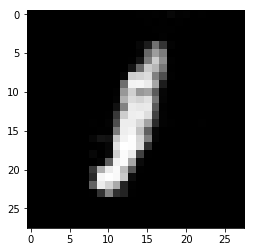

Epoch 2/2... Discriminator Loss: 1.3135... Generator Loss: 0.9947
Epoch 2/2... Discriminator Loss: 1.3484... Generator Loss: 0.6897
Epoch 2/2... Discriminator Loss: 1.2649... Generator Loss: 0.6591
Epoch 2/2... Discriminator Loss: 1.2602... Generator Loss: 0.7986
Epoch 2/2... Discriminator Loss: 1.3095... Generator Loss: 0.6276


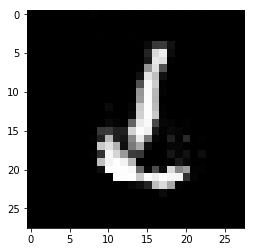

Epoch 2/2... Discriminator Loss: 1.1507... Generator Loss: 0.7366
Epoch 2/2... Discriminator Loss: 1.5118... Generator Loss: 0.6228
Epoch 2/2... Discriminator Loss: 1.2810... Generator Loss: 0.6413
Epoch 2/2... Discriminator Loss: 1.2334... Generator Loss: 0.7355
Epoch 2/2... Discriminator Loss: 1.3773... Generator Loss: 0.6481


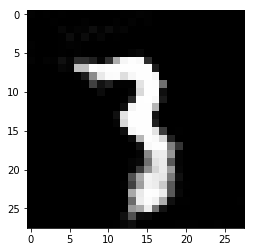

Epoch 2/2... Discriminator Loss: 1.4507... Generator Loss: 0.5920
Epoch 2/2... Discriminator Loss: 1.2860... Generator Loss: 0.6343
Epoch 2/2... Discriminator Loss: 1.3955... Generator Loss: 0.5948
Epoch 2/2... Discriminator Loss: 1.3155... Generator Loss: 0.6825
Epoch 2/2... Discriminator Loss: 1.4081... Generator Loss: 0.6176


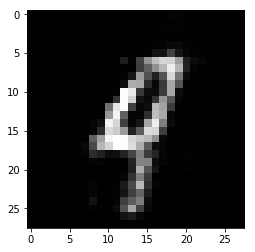

Epoch 2/2... Discriminator Loss: 1.5165... Generator Loss: 0.5179
Epoch 2/2... Discriminator Loss: 1.1856... Generator Loss: 0.8470
Epoch 2/2... Discriminator Loss: 1.3033... Generator Loss: 0.8971
Epoch 2/2... Discriminator Loss: 1.0720... Generator Loss: 0.7109
Epoch 2/2... Discriminator Loss: 1.1990... Generator Loss: 0.8012


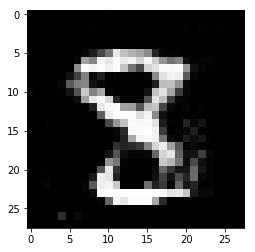

Epoch 2/2... Discriminator Loss: 1.1929... Generator Loss: 0.7404
Epoch 2/2... Discriminator Loss: 1.2820... Generator Loss: 0.7234
Epoch 2/2... Discriminator Loss: 1.2742... Generator Loss: 0.7221
Epoch 2/2... Discriminator Loss: 1.4000... Generator Loss: 0.6486
Epoch 2/2... Discriminator Loss: 1.1124... Generator Loss: 0.8129


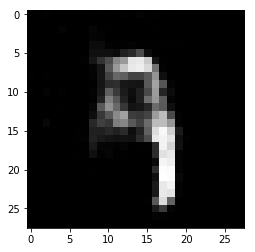

Epoch 2/2... Discriminator Loss: 1.3610... Generator Loss: 0.8071
Epoch 2/2... Discriminator Loss: 1.2441... Generator Loss: 0.7534
Epoch 2/2... Discriminator Loss: 1.2729... Generator Loss: 0.7259
Epoch 2/2... Discriminator Loss: 1.4244... Generator Loss: 0.6944
Epoch 2/2... Discriminator Loss: 1.4153... Generator Loss: 0.7733


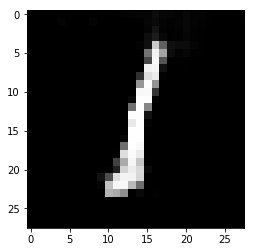

Epoch 2/2... Discriminator Loss: 1.3924... Generator Loss: 0.5899
Epoch 2/2... Discriminator Loss: 1.1318... Generator Loss: 0.8811
Epoch 2/2... Discriminator Loss: 1.3399... Generator Loss: 0.6584
Epoch 2/2... Discriminator Loss: 1.3876... Generator Loss: 0.8107
Epoch 2/2... Discriminator Loss: 1.2633... Generator Loss: 0.7899


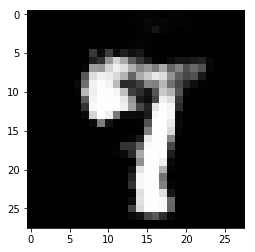

Epoch 2/2... Discriminator Loss: 1.4208... Generator Loss: 0.5887
Epoch 2/2... Discriminator Loss: 1.4242... Generator Loss: 0.5819
Epoch 2/2... Discriminator Loss: 1.2096... Generator Loss: 0.6410
Epoch 2/2... Discriminator Loss: 1.2668... Generator Loss: 0.8012
Epoch 2/2... Discriminator Loss: 1.4749... Generator Loss: 0.5794


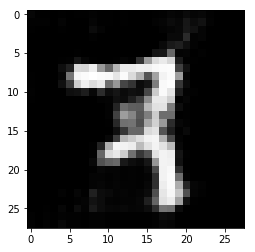

Epoch 2/2... Discriminator Loss: 1.3299... Generator Loss: 0.5847
Epoch 2/2... Discriminator Loss: 1.4231... Generator Loss: 0.7036
Epoch 2/2... Discriminator Loss: 1.3174... Generator Loss: 0.6534
Epoch 2/2... Discriminator Loss: 1.3264... Generator Loss: 0.6928
Epoch 2/2... Discriminator Loss: 1.2726... Generator Loss: 0.6959


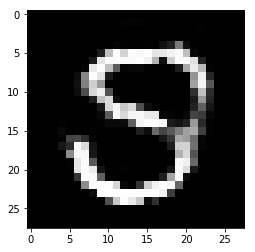

IndexError: list index out of range

In [37]:
batch_size = 10
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0032... Generator Loss: 17.1946
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 16.1289
Epoch 1/1... Discriminator Loss: 0.1806... Generator Loss: 8.9238
Epoch 1/1... Discriminator Loss: 2.5002... Generator Loss: 0.5269
Epoch 1/1... Discriminator Loss: 0.0247... Generator Loss: 5.3910


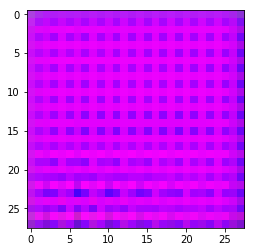

Epoch 1/1... Discriminator Loss: 0.1963... Generator Loss: 2.4501
Epoch 1/1... Discriminator Loss: 2.0614... Generator Loss: 0.9092
Epoch 1/1... Discriminator Loss: 1.7448... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 0.3679... Generator Loss: 3.4327
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 1.6222


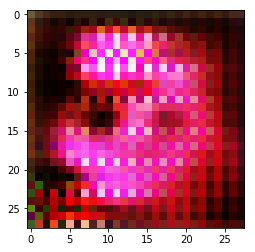

Epoch 1/1... Discriminator Loss: 0.4992... Generator Loss: 2.5099
Epoch 1/1... Discriminator Loss: 0.6650... Generator Loss: 1.6547
Epoch 1/1... Discriminator Loss: 1.7940... Generator Loss: 2.1422
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 1.1525
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 0.9182


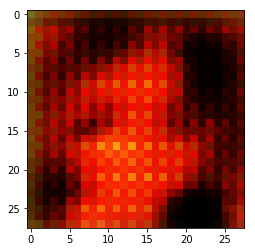

Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 0.9744
Epoch 1/1... Discriminator Loss: 0.8356... Generator Loss: 1.4665
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 1.3752
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 1.0870
Epoch 1/1... Discriminator Loss: 0.7529... Generator Loss: 1.1867


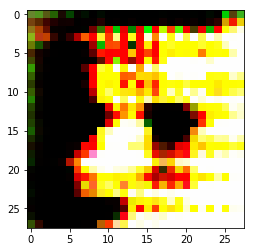

Epoch 1/1... Discriminator Loss: 0.3837... Generator Loss: 2.1009
Epoch 1/1... Discriminator Loss: 0.2096... Generator Loss: 4.2087
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 0.3916... Generator Loss: 2.0085
Epoch 1/1... Discriminator Loss: 0.5626... Generator Loss: 2.0429


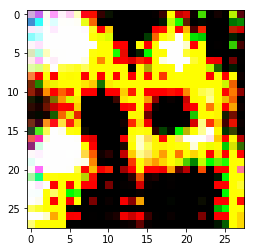

Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 2.0046... Generator Loss: 6.6783
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 1.1724
Epoch 1/1... Discriminator Loss: 0.6061... Generator Loss: 1.4300
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.5935


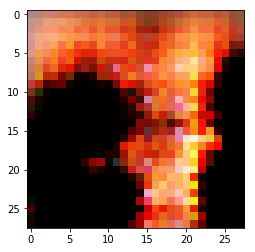

Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 1.7281
Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 2.0974
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 5.3418
Epoch 1/1... Discriminator Loss: 0.6175... Generator Loss: 1.3634
Epoch 1/1... Discriminator Loss: 2.5528... Generator Loss: 4.2213


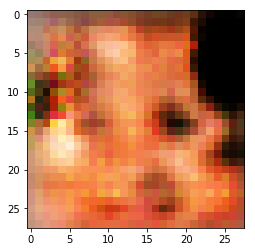

Epoch 1/1... Discriminator Loss: 2.2279... Generator Loss: 3.6135
Epoch 1/1... Discriminator Loss: 0.1609... Generator Loss: 2.5645
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 3.8673
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 3.2689
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.4494


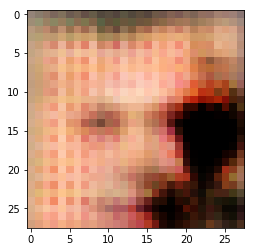

Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 1.2190
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 3.4152
Epoch 1/1... Discriminator Loss: 2.2558... Generator Loss: 0.1848
Epoch 1/1... Discriminator Loss: 2.2232... Generator Loss: 2.7725
Epoch 1/1... Discriminator Loss: 1.9336... Generator Loss: 0.2659


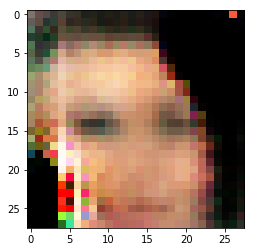

Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 2.2435... Generator Loss: 4.6208
Epoch 1/1... Discriminator Loss: 2.0363... Generator Loss: 0.2579
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 2.8523
Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 1.6042


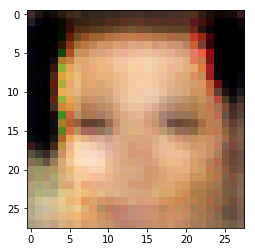

Epoch 1/1... Discriminator Loss: 2.2410... Generator Loss: 3.1394
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 1.1712
Epoch 1/1... Discriminator Loss: 1.6042... Generator Loss: 0.3297
Epoch 1/1... Discriminator Loss: 0.8594... Generator Loss: 2.4928
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.8831


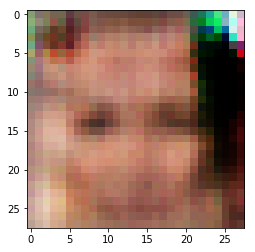

Epoch 1/1... Discriminator Loss: 0.8267... Generator Loss: 1.0663
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 2.0914
Epoch 1/1... Discriminator Loss: 1.7129... Generator Loss: 2.3986
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.3702
Epoch 1/1... Discriminator Loss: 2.1239... Generator Loss: 2.2222


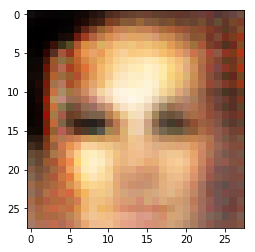

Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 0.6985... Generator Loss: 1.3906
Epoch 1/1... Discriminator Loss: 2.1578... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 1.3345
Epoch 1/1... Discriminator Loss: 1.8641... Generator Loss: 2.9669


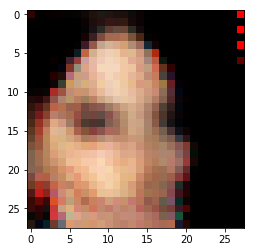

Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 1.7966
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 1.5177
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 1.0862


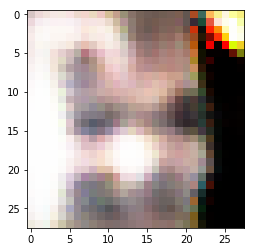

Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 0.3024
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.4183
Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 1.5138
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.8136


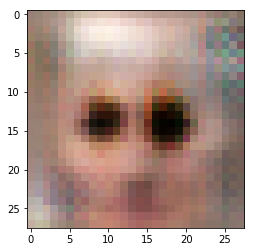

Epoch 1/1... Discriminator Loss: 1.6994... Generator Loss: 0.4153
Epoch 1/1... Discriminator Loss: 1.7622... Generator Loss: 1.7277
Epoch 1/1... Discriminator Loss: 1.7571... Generator Loss: 0.3041
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.3884
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 0.6963


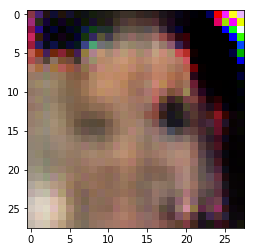

Epoch 1/1... Discriminator Loss: 1.8372... Generator Loss: 1.0886
Epoch 1/1... Discriminator Loss: 1.6041... Generator Loss: 0.4842
Epoch 1/1... Discriminator Loss: 1.5913... Generator Loss: 0.4224
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 1.1539
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.7862


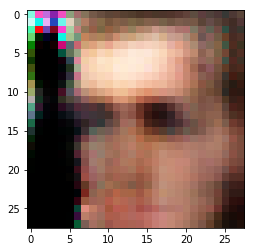

Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 1.8196... Generator Loss: 0.2962
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 1.1374


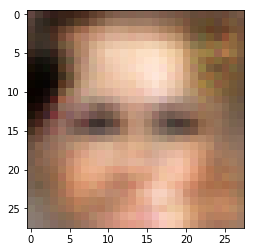

Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.8803... Generator Loss: 2.2707
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.5339


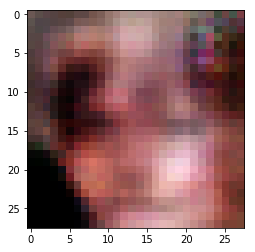

Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 1.7086... Generator Loss: 0.3858
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.5172
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 2.1525


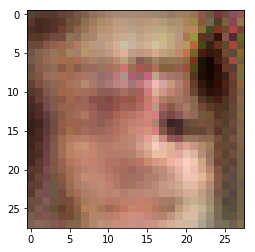

Epoch 1/1... Discriminator Loss: 1.8850... Generator Loss: 0.3362
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 1.0372
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 1.2483
Epoch 1/1... Discriminator Loss: 2.1310... Generator Loss: 0.1885
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.4974


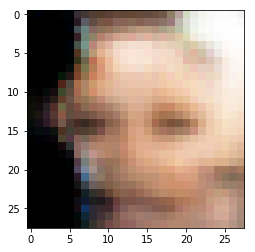

Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 1.0731
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.4578
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.4218


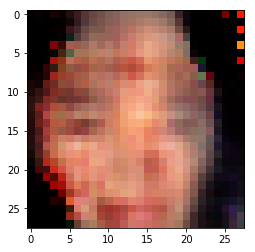

Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 1.2058
Epoch 1/1... Discriminator Loss: 1.5840... Generator Loss: 1.3492
Epoch 1/1... Discriminator Loss: 1.6704... Generator Loss: 2.0310
Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 1.7755
Epoch 1/1... Discriminator Loss: 1.7189... Generator Loss: 2.0869


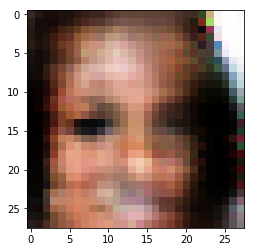

Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 2.2201... Generator Loss: 2.4691
Epoch 1/1... Discriminator Loss: 2.1834... Generator Loss: 1.8246
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.6485


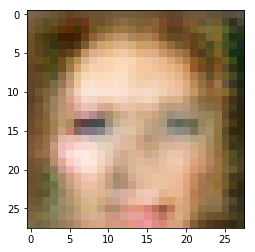

Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.4276
Epoch 1/1... Discriminator Loss: 1.6989... Generator Loss: 0.3224
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 0.8655


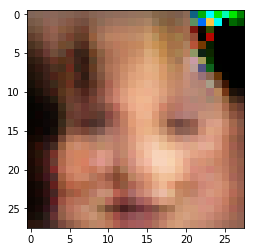

Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 1.1467
Epoch 1/1... Discriminator Loss: 2.0811... Generator Loss: 0.1969
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.5194
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.6252


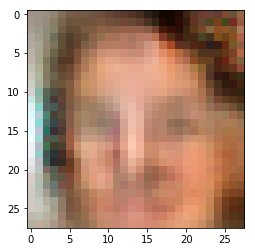

Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.5863... Generator Loss: 1.9947
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.3850


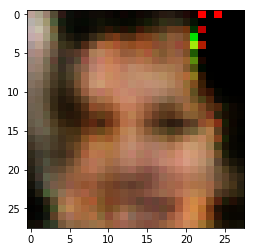

Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 1.5540
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.4298


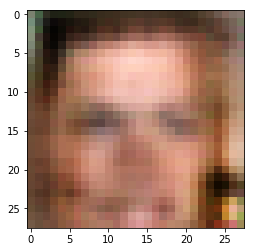

Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.4920
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 1.1266
Epoch 1/1... Discriminator Loss: 1.6275... Generator Loss: 0.3386


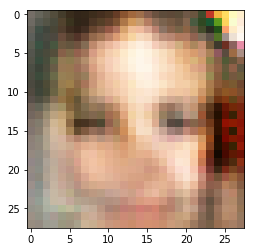

Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 1.1802
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.7884


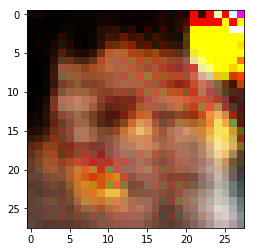

Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 1.9216
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 1.9547... Generator Loss: 0.4275
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 1.0716


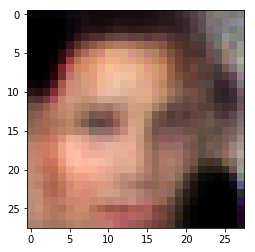

Epoch 1/1... Discriminator Loss: 1.6682... Generator Loss: 1.6001
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 1.4207


IndexError: list index out of range

In [38]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.